<a href="https://colab.research.google.com/github/oromiaGodanna/Brain-Imaging_2022_VU/blob/main/Copy_of_glm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuroimaging week 2: modeling fMRI with the GLM

This week will be all about how most fMRI analyses are done: using the **GLM**.
We'll use example data for this notebook, the notebook assumes it's stored in a folder next to the notebook called `data`. You can download these data from Canvas, or the course GitHub page. 

When you upload these data to CoLab, make sure that you're pointing the data in the right direction. If you've saved the data to your `Colab Notebooks/data` folder, that is the following location: `/content/drive/My Drive/Colab Notebooks/data/`. The code below tries to set it up so that you don't need to worry about it.

In [ ]:
# this will ask you to authenticate with Google
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Mounted at /content/drive


## About this week's lab
The GLM, or the General Linear Model, is a statistical model that underlies a range of statistical models that you're probably already familiar with: (M)ANOVA, t-test, F-test, and most importantly ordinary *linear regression*. 

Basically, the type of fMRI analysis you are going to learn in this course (often called 'univariate analysis' or 'Statistical Parametric Mapping') is just an ordinary linear regression model adapted to time-series data. We are going to assume that you know the basics of linear regression, such as what a beta-parameter is, what R-squared means, and what residuals are (but we'll give you a short recap on these concepts). 

Given that you have some basic familiarity with these concepts, you will see during this tutorial that univariate fMRI analyses using the GLM are actually very straightforward. However, while relatively simple, it is **VERY** important that you understand all the concepts in this tutorial thoroughly, because it will be the basis for ALL the upcoming lectures and tutorials from this course. You will definitely use what you learn here in the Project. 

As a consequence of the importance of the GLM, this week's lab is probably going to take quite long again (substantially longer than the upcoming weeks). So, you'll have to work hard this week, but it'll definitely pay off. Also, the material will seem quite mathematical, but it often serves a symbolic purpose: to show you how results (e.g. t-statistics) are influenced by different parts of the formulas within the GLM. Moreover, after showing and explaining you the formulas, we'll work it out in code examples (which are often *way* easier to understand!). Also, after explaining a certain aspect of the GLM, we'll ask you to think about it and practice with it in ToThink and ToDo questions.

That being said, by working through this tutorial and understanding the concepts it will introduce, you will have completed the most difficult and most elaborate part of this course; from here on, it will only get easier (and will take less time)!

## What you'll learn
After this week's lab ... 
* you know how the GLM is applied to fMRI data 
* you are able to implement a univariate (single-voxel) t-test from scratch in Python

**Estimated time needed to complete**: 8-12 hours

## 1. Recap of linear regression
To refresh your memory on linear regression, we'll walk you through a recap of the technique's most important concepts.
We are going to work through a simple example. 

In the code below, `y` will denote our *dependent variable* (the variable we try to model/explain) and `X` will denote our *independent variable(s)* (the variables we're using to try to explain `y`). Throughout the entire tutorial will use `X` to refer to our matrix of independent variables (also called "predictors" or "regressors", or simply "design matrix") and use `y` to refer to our dependent variable (also sometimes called "target").

Moreover, the independent variables are often grouped in a single matrix (a 2D array, so to speak) - which is sometimes called the "design matrix" (because it 'designs' the way we want to model our dependent variable). As stated before, in this tutorial we store our design matrix - the set of our independent variables - in the variable `X` (or slight variations on that, like `X_new` or something). Importantly, it is often assumed (e.g. by statistics functions/software) that the design matrix takes the shape of $N\ (observations) \times P\ (predictors)$. So, the rows refer to the sampled observations (also often called "samples", "instances", or simply "data points"). The columns refer to the separate independent variables that we use to model the dependent variable. For the dependent variable, it is often assumed that this is a single row-vector of shape $N \times 1$.

### 1.1. Notation
Next, let's define some more conventions in notation. We will denote the total number of observations with **$N$**. Moreover, we'll denote **$i$** as the index of samples. To give an example, the formula below gives you the sum of our target variable:

\begin{align}
\mathrm{sum}(y) = \sum_{i=1}^{N} y_{i} 
\end{align}

Lastly, we denote the total number of predictors **$P$** and  **$j$** as the index of our predictors. So, for example, if we wanted to sum over our predictors for a given sample **$i$**, we'd write: 

\begin{align}
\mathrm{sum}(X_{i}) = \sum_{j=1}^{P} X_{ij} 
\end{align}

To practice with this notation, let's do a ToDo!

In [ ]:
# First some imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

From the variable `arr` below (an array of shape $100 \times 25$), calculate the mean over all samples ($N$) for the predictor at index $j = 4$ (i.e., the fourth predictor). Store the result in a variable named `mean_predictor_4`.

Remember: Python has 0-based indexing!

In [ ]:
np.random.seed(42)
arr = np.random.normal(0, 1, size=(100, 25))
# Implement your ToDo here
mean_predictor_4 = np.sum(arr[:, 3]/arr.shape[0])
print(mean_predictor_4)


0.08591373616660723


In [ ]:
'''Tests the above ToDo. '''
np.testing.assert_almost_equal(mean_predictor_4, np.mean(arr[:, 3]))

Now, let's look at an example. Throughout the example below, we will gradually explain the components of linear regression. For the example, we will use randomly generated data to create a dependent variable with 30 observations ("samples"; $N = 30$) and a single independent variable ($P = 1$) with, of course, also 30 observations. So both the independent and dependent variable are of shape $30 \times 1$. Alright, let's get started!

First, we have to import a Python implementation of linear regression. We'll use the `lstsq` ("least squares") function from the `linalg` (linear algebra) subpackage of `numpy`, but we could have also used `scipy` or `sklearn` implementations - they're all the same under the hood.

In [ ]:
from numpy.linalg import lstsq

Now, for our example let's create some randomly generated data. As discussed, we'll create two variables (of shape $30\times 1$), which have a prespecified correlation of 0.8 (normally, you don't know this before doing the analysis of course, but we specify it here for the sake of the example). 

We'll denote our independent variable `X` and our dependent variable `y`.

In [ ]:
np.random.seed(1)

prespecified_covariance = np.array([[1, .8],
                                    [.8, 1]])

data = np.random.multivariate_normal(mean=[3, 7], cov=prespecified_covariance, size=30)
print(data)
""" By default, when you slice out a single column (or row), numpy returns
an array of shape (some_number,) instead of (some_number, 1). However, for our
examples, we often actually want shape (some_number, 1) so essentially we want to 
"add" an extra axis. This is done by the np.newaxis command. Mess around with
it yourself to see how it works! """
print(data[:,0, np.newaxis])
X = data[:, 0, np.newaxis] # Here, we slice the first column (0) and immediately add a new axis!
y = data[:, 1, np.newaxis] # same here

print('The shape of X is: %s' % (X.shape,))
print('The shape of y is: %s' % (y.shape,))

[[1.65246505 5.26555632]
 [3.84037019 7.16176525]
 [2.90681268 5.4511918 ]
 [1.58544098 5.10401146]
 [2.77619077 6.6184751 ]
 [2.26439631 4.96144893]
 [3.42732047 7.18442317]
 [2.27222802 5.57659571]
 [3.44118297 6.88597655]
 [2.77565017 7.14425488]
 [3.68214561 8.40613245]
 [1.98577328 6.3035786 ]
 [2.36158674 5.92915927]
 [3.41250018 6.82066763]
 [3.08642782 7.42185407]
 [3.78163148 7.53070252]
 [3.91918676 7.38463177]
 [3.64080489 7.6327951 ]
 [3.98584491 8.13410242]
 [1.19071843 5.66002836]
 [3.46268411 6.90129826]
 [3.17361546 8.24401773]
 [3.15323524 6.75036382]
 [2.15472268 7.48304066]
 [2.69083045 7.08118397]
 [2.82662461 6.60384225]
 [4.1943598  7.97341606]
 [3.01266793 7.38368101]
 [1.90963012 6.49851078]
 [2.44916186 7.00897429]]
[[1.65246505]
 [3.84037019]
 [2.90681268]
 [1.58544098]
 [2.77619077]
 [2.26439631]
 [3.42732047]
 [2.27222802]
 [3.44118297]
 [2.77565017]
 [3.68214561]
 [1.98577328]
 [2.36158674]
 [3.41250018]
 [3.08642782]
 [3.78163148]
 [3.91918676]
 [3.6408048

### 1.2. Modeling the intercept (offset)
As you probably were told in your previous statistics classes, you should always "model the intercept" when running any (regression) model. Technically, the intercept models some of the signal using a constant term. The parameter corresponding to the intercept (as calculated by linear regression), then, refers to *the average value of your $y$ variable when all predictors in $X$ are 0*. So, conceptually, the intercept models the mean when controlling for our (other) predictors.

To "model the intercept", you should add an extra "constant predictor" to your design matrix (`X`). This "constant predictor" means simply an array of shape $N \times 1$ with a constant value, usually all ones. (You'll figure out *why* you should do this later in the tutorial.)

Remember from week 1 how to create an array with ones? We can just use `np.ones(shape_of_desired_array)`!

In [ ]:
n_obs = y.size
intercept = np.ones((n_obs, 1))  # creates intercept of shape (N, 1)

Now, we want to add it to our design matrix (`X`). We can do this using the numpy function `np.hstack` (which is short for "horizontal stack", i.e. "stacking columns horizontally"). This function takes a tuple with arrays which show have the same amount of rows (for our data: both have 30 rows) and returns the a new array in which the arrays from the tuple are stacked (stacked shape should be $30 \times 2$):

In [ ]:
tuple_with_arrays = (intercept, X)
X_with_icept = np.hstack(tuple_with_arrays)

# Note: you could also simply do ...
# X_with_icept = np.hstack((np.ones((y.size, 1)), X))
# ... but arguably this is less 'readable' than the implementation above

print("Shape of X is now: %s" % (X_with_icept.shape,))

Shape of X is now: (30, 2)


Let's take a look at the X matrix ("design matrix") we have now. As you'll see, we have two columns: the first one is our intercept-predictor, and the second one is our 'regular' predictor.

In [ ]:
print(X_with_icept)

[[1.         1.65246505]
 [1.         3.84037019]
 [1.         2.90681268]
 [1.         1.58544098]
 [1.         2.77619077]
 [1.         2.26439631]
 [1.         3.42732047]
 [1.         2.27222802]
 [1.         3.44118297]
 [1.         2.77565017]
 [1.         3.68214561]
 [1.         1.98577328]
 [1.         2.36158674]
 [1.         3.41250018]
 [1.         3.08642782]
 [1.         3.78163148]
 [1.         3.91918676]
 [1.         3.64080489]
 [1.         3.98584491]
 [1.         1.19071843]
 [1.         3.46268411]
 [1.         3.17361546]
 [1.         3.15323524]
 [1.         2.15472268]
 [1.         2.69083045]
 [1.         2.82662461]
 [1.         4.1943598 ]
 [1.         3.01266793]
 [1.         1.90963012]
 [1.         2.44916186]]


Now, let's take a look at the data. We'll create a scatter-plot for this (we'll leave out the intercept):

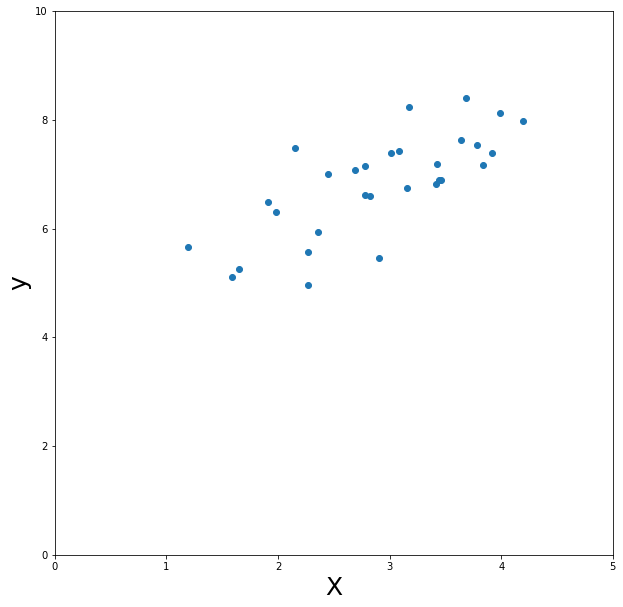

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X_with_icept[:, 1], y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
plt.show()

### 1.3. Interpreting parameters in linear regression
As you can see, there seems to be some positive linear relationship between $X$ (just the independent variable without the intercept) and $y$. In other words, an increase in $X$ will lead to an increase in $y$. But, at this moment, *how much exactly* $y$ changes for a increase in $X$ is unknown. By doing a linear regression with $X$ as our predictor of $y$, we can quantify this! 

The parameter, i.e. the "thing" that quantifies the influence of $X$ on $y$, calculated by this model is often called the **beta-parameter(s)** (but sometimes they're denoted as theta, or any other greek symbol/letter). The beta-parameter quantifies exactly how much $y$ changes if you increase $X$ by 1. Or, in other words, it quantifies how much influence $X$ has on $y$. In a formula ($\delta$ stands for "change in")\*: 

\begin{align}
\beta_{j} = \frac{\delta y}{\delta X_{j}} 
\end{align}

As you probably realize, each predictor in $X$ (i.e., $X_{j}$) has a parameter ($\beta_{j}$) that quantifies how much influence that predictor has on our target variable ($y$). This includes the intercept, our vector of ones (which is in textbooks often denoted by $\beta_{0}$; they often don't write out $\beta_{0}X_{0}$ because, if a vector of ones is used, $\beta_{0}\cdot 1$ simplifies to $\beta_{0}$).

Thus, linear regression describes a model in which a set of beta-parameters are calculated to characterize the influence of each predictor in $X$ on $y$, that together explain $y$ as well as possible (but the model is usually not perfect, so there will be some *error*, or "unexplained variance"). As such, we can formulate the linear regression model as follows:

\begin{align}
y = \beta_{0} + X_{1}\beta_{1} + X_{2}\beta_{2} ... + X_{P}\beta_{P} + \epsilon
\end{align}

which is often written out as (and is equivalent to the formula above):

\begin{align}
y = \sum_{j=1}^{P}X_{j}\beta_{j} + \epsilon
\end{align}

Here, $\epsilon$ is the variance of $y$ that cannot be explained by our predictors (i.e, the *error*). 

But how does linear regression calculate the beta-parameters? The method most often used is called **'ordinary least squares'** (OLS; or just 'least squares' - remember the "`from numpy.linalg import lstsq`" ?). This method tries to find a "weight(s)" for the independent variable(s) such that when you multiply the weight(s) with the independent variable(s), it produces an estimate of $y$ (often denoted as $\hat{y}$, or "y-hat") that is as 'close' to the true $y$ as possible. In other words, least squares tries to 'choose' the beta-parameter(s) such that the difference between $X$ multiplied with the beta(s) (i.e. our best guess of $y$, denoted as $\hat{y}$) and the true $y$ is minimized\*. 

Let's just formalize this formula for the 'best estimate of $y$' (i.e. $\hat{y}$):

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\beta_{j} 
\end{align}

--------
\* Actually, least squares yields *an estimate* of the "true" (i.e. the population) beta-parameter. Usually, therefore, the beta-parameter is denoted with a "hat" ($\hat{\beta}$), to indicate that it is estimated, but because that clutters the formulas too much, we leave out the hat.

Before we're going into the estimation of these beta-parameters, let's practice with calculating $\hat{y}$!

<div class='alert alert-warning'>
    <b>ToDo</b> 
</div>

Below, we've defined a design matrix with two predictors (`this_X`) and an array with beta-estimates (`these_betas`; just pretend that these betas were estimated by us beforehand). Now, given this data, can you calculate the predicted $y$-values (i.e., $\hat{y}$)? Store these predicted $y$-values in an array named `this_y_hat`.

Hint: your `this_y_hat` array should be of shape `(100,)`

In [ ]:
this_X = np.random.normal(0, 1, (100, 2))
these_betas = np.array([5, 3])

this_y_hat = this_X.dot(these_betas)

In [ ]:
''' Tests the above ToDo'''
np.testing.assert_array_almost_equal(this_X.dot(these_betas), this_y_hat)

In ordinary least squares, the difference that is tried to be minized is expressed as the sum of squared differences (hence the name 'least squares'!): 

\begin{align}
\min_{\beta} \sum_{i=1}^{N}\sum_{j=1}^{P}(y_{i} - X_{ij}\hat{\beta}_{j})^2 
\end{align}

While it may look daunting, this formula simply says: "find the beta(s) that minimize the difference of my prediction of $y$ (calculated as $X \cdot \beta$) and the true $y$. While the book describes how OLS finds beta-parameters (namely by the vectorized formula: $\beta = (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'y$), we don't expect you to understand how this works exactly. But you should understand the objective of least squares (minimizing prediction of $y$ and true $y$) and what role the beta-parameters play in this process (i.e. a kind of weighting factor of the predictors).

Alright, that's a lot of text (and math, ugh...). Let's actually run least squares to get the beta-parameters of our model!

In [ ]:
# Note the inputs to lstsq: the design matrix (X) and the dependent variable (y)
# We also input "rcond=None"; this is only to silence a warning from numpy,
# it doesn't change the function itself (you can ignore this for now)

output_lstsq = lstsq(X_with_icept, y, rcond=None)
beta = output_lstsq[0]
print('The betas of my model are: %r' % beta.tolist())

# Also note that there are more outputs of the function lstsq().
# For now, we're only interested in the first output, which are the model's estimates betas.
# To get these, we immediately index the outputs by [0]
# We could have done this more concisely by (but didn't for clarity):
# beta = lstsq(X_with_icept, y, rcond=None)[0]

The betas of my model are: [[4.258979625276838], [0.8818620283931744]]


"What? Why are there two beta-parameters?", you might think. This is of course because you also use the intercept as a predictor, which also has an associated beta-value (weighting factor). Here, the first beta refers to the intercept of the model (because it's the first column in the design-matrix)! The second beta refers to our 'original' predictor. Thus, the model found by least squares for our generated data is (i.e. that leads to our best estimate of $y$, i.e. $\hat{y}$:

\begin{align}
\hat{y} = X_{1} \cdot 4.259 + X_{2} \cdot 0.882 
\end{align}

And since our intercept (here $X_{1}$) is a vector of ones, the formula simplifies to:

\begin{align}
\hat{y} = 4.259 + X_{2} \cdot 0.882
\end{align}

Now, let's calculate our predicted value of $y$ ($\hat{y}$) by implementing the above formula by multiplying our betas with the corresponding predictors (intercept and original predictor). Here, because we have two predictors, we simply add the two "`predictor * beta`" terms to get the final $\hat{y}$.

In [ ]:
y_hat = X_with_icept[:, 0] * beta[0] + X_with_icept[:, 1] * beta[1]
print('The predicted y-values are: \n\n%r' % y_hat)

The predicted y-values are: 

array([5.7162258 , 7.64565627, 6.82238735, 5.65711982, 6.70719685,
       6.25586475, 7.2814034 , 6.26277124, 7.29362822, 6.70672011,
       7.50612402, 6.01015768, 6.3415733 , 7.26833396, 6.98078313,
       7.59385684, 7.71516161, 7.46966721, 7.77394491, 5.30902899,
       7.31258926, 7.05767059, 7.03969805, 6.15914774, 6.63192082,
       6.75167254, 7.95782627, 6.91573708, 5.94300991, 6.41880247])


Actually, using matrix algebra (which is often used in the text book), there is a 'trick' to quickly sum the results of two vector multiplications, called the dot-product. Check it out below:

In [ ]:
y_hat2 = X_with_icept.dot(beta)
print('The predicted y-values (using dot-product) are: \n\n%r' % y_hat2.T)

The predicted y-values (using dot-product) are: 

array([[5.7162258 , 7.64565627, 6.82238735, 5.65711982, 6.70719685,
        6.25586475, 7.2814034 , 6.26277124, 7.29362822, 6.70672011,
        7.50612402, 6.01015768, 6.3415733 , 7.26833396, 6.98078313,
        7.59385684, 7.71516161, 7.46966721, 7.77394491, 5.30902899,
        7.31258926, 7.05767059, 7.03969805, 6.15914774, 6.63192082,
        6.75167254, 7.95782627, 6.91573708, 5.94300991, 6.41880247]])


In this (and upcoming) tutorials, you probably see the dot-notation for matrix multiplication more often, so understand that it (in this context) simply multiplies the columns of X with the corresponding betas and (element-wise) sums these columns to get the $\hat{y}$ values! Thus, this notation:

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

... is exactly the same as the dot-product notation using matrix algebra:

\begin{align}
\hat{y}_{i} = \mathbf{X}_{i}\mathbf{\hat{\beta}} 
\end{align}

You can usually recognize the implementations in formulas using algebra by the use of bold variables (such as $\mathbf{X}$) here above.

*You will calculate `y_hat` quite a lot throughout this lab; please use the dot-product-method to calculate `y_hat`, because this will prevent errors in the future!* So, use this ...

```python
y_hat = X.dot(betas)
```

instead of ...

```python
y_hat = X[:, 0] * betas[0] + X[:, 1] * betas[1]
```

Now, let's plot the predicted $y$ values ($\hat{y}$) against the true $y$ values ($y$).

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
x_lim = (0, 5)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_hat = X_with_icept.dot(beta) # using the matrix algebra approach!
plt.plot(X, y_hat, marker='.', c='tab:orange', markersize=10)
plt.legend(['Predicted y', 'True y'])
plt.show()

NameError: ignored

<Figure size 720x720 with 0 Axes>

Actually, let's just plot the predicted y-values as a line (effectively interpolating between adjacent predictions) - this gives us the linear regression plot as you've probably seen many times in your statistics classes!

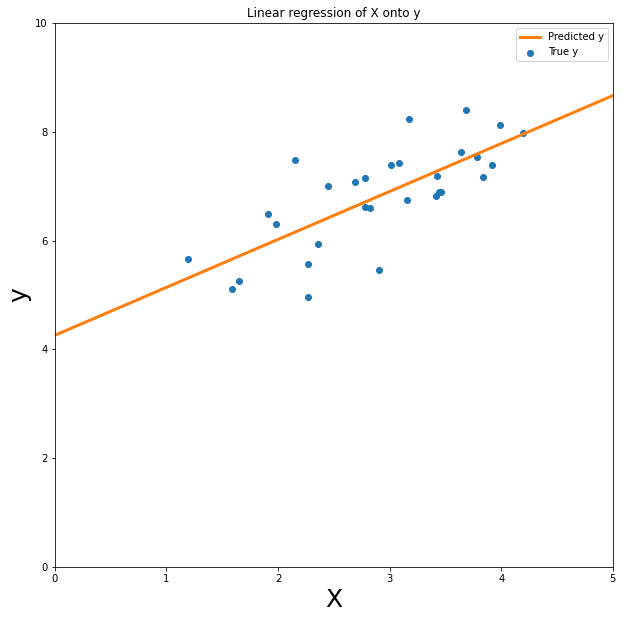

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = beta[0] + beta[1] * x_lim[0]
y_max_pred = beta[0] + beta[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='tab:orange', lw=3)
plt.legend(['Predicted y', 'True y'])
plt.title('Linear regression of X onto y')
plt.show()

### 1.4. Residuals and model fit
Alright, so now we have established the beta-values that lead to the best prediction of $y$ - in other words, the best fit of our model. But how do we quantify the fit of our model? One way is to look at the difference between $\hat{y}$ and y, which is often referred to as the model's **residuals**. This difference between $\hat{y}$ and $y$ - the residuals - is the exact same thing as the $\epsilon$ in the linear regression model, i.e. the **error** of the model. Thus: 

\begin{align}
residual = y - \hat{y} = \epsilon 
\end{align}

To visualize the residuals (plotted as red dashed lines):

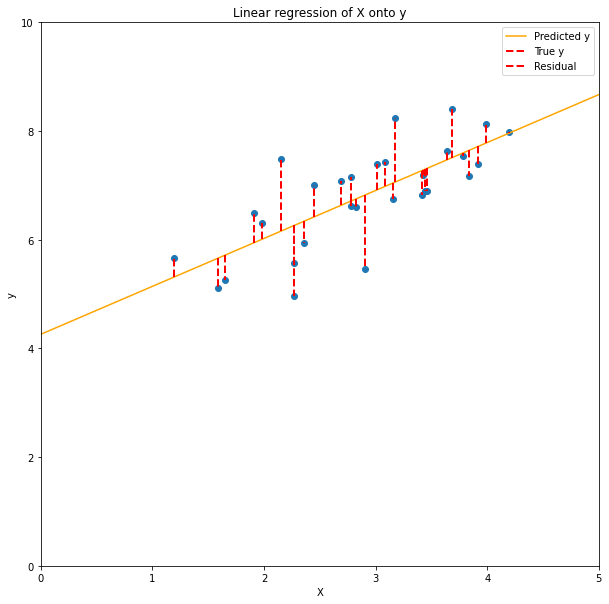

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = beta[0] + beta[1] * x_lim[0]
y_max_pred = beta[0] + beta[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange')
plt.title('Linear regression of X onto y')

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat[i], y[i]), linestyle='--', c='red', lw=2)

plt.legend(['Predicted y', 'True y', 'Residual'])
plt.show()

In fact, the model fit is often summarized as the **mean of the squared residuals** (also called the 'mean squared error' or MSE), which is thus simply the (length of the) red lines squared and averaged. In other words, the MSE refers to the average squared difference between our predicted $y$ and the true $y$\*:

\begin{align}
MSE = \frac{1}{N}\sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2
\end{align}

\* The "$\frac{1}{N}\sum_{i=1}^{N}$" is just a different (but equally correct) way of writing "the average of all residuals from sample 1 to sample N".

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Calculate the MSE for our previous model predictions (`y_hat`) based on our linear regression model predicting `y` from `X_with_intercept`. *Do not use a for-loop for this.* You know how to do this without a loop, using vectorized numpy array math. Store the result in a variable named `mse`.

In [ ]:
# Implement your ToDo here
mse = np.sum(np.square(y - y_hat))/y.size
print(mse == np.mean((y - y_hat) ** 2))

True


In [ ]:
''' Tests the above ToDo. '''
np.testing.assert_almost_equal(mse, np.mean((y - y_hat) ** 2))

Another metric for model fit in linear regression is "R-squared" ($R²$). R-squared is calculated as follows:

\begin{align}
R^2 = 1 - \frac{\sum_{i=1}^{N}(y_{i} - X_{i}\hat{\beta})^2}{\sum_{i=1}^{N}(y_{i} - \bar{y})^2}
\end{align}

where $\bar{y}$ represents the mean of $y$. As you can see, the formula for R-squared consists of two parts: the numerator ($\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^2$) and the denominator ($\sum_{i=1}^{N}(y_{i} - \bar{y}_{i})^2$). The denominator represents the *total* amount of squared error of the actual values ($y$) relative to the mean ($\bar{y}$). The numerator represents the *reduced* squared errors when incorporating knowledge from our (weighted) independent variables ($X_{i}\hat{\beta}$). So, in a way you can interpret R-squared as *how much better my model is including `X` versus a model that only uses the mean*. Another conventional interpretation of R-squared is the amount of variance our predictors ($X$) together can explain of our target ($y$).

As expected, the code is quite straightforward:

In [ ]:
numerator = np.sum((y - y_hat) ** 2)  # remember, y_hat equals X * beta
denominator = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - numerator / denominator

print('The R² value is: %.3f' % r_squared)

The R² value is: 0.549


<div class='alert alert-warning'>
    <b>ToDo</b> 
</div>

Below, we've defined a design matrix (`X_test`, including an intercept) and a dependent variable (`y_test`). Run a linear regression model and calculate R-squared. Store the R-squared value (which should be a single number, a float) in a variable named `r_squared_test`.

In [ ]:

data_tmp = np.load('/content/drive/MyDrive/Colab Notebooks/data/data_todo_rsquared.npz')
X_test, y_test = data_tmp['X'], data_tmp['y']

b = lstsq(X_test, y_test, rcond=None)
y_test_hat = X_test.dot(b[0])
nominator_test = np.sum((y_test - y_test_hat)**2)
denominator_test = np.sum((y_test - np.mean(y_test))**2)
r_squared_test = 1 - (nominator_test/denominator_test)
print(r_squared_test)

0.3632447637875489


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div class='alert alert-info'>
<b>ToThink</b>
</div>

As discussed earlier, it's important to model the intercept in regression models. This is because it often greatly *improves model fit*! In this ToThink, you have to explain *why* modelling the intercept (usually) improves model fit. 

To give you some clues, we re-did the linear regression computation from above, but now without the intercept in the design matrix. We plotted the data (`X_no_icept`, `y`) and the model fit to get some intuition about the use of an intercept in models. 

In the text-cell below the plot, explain (concisely!) why modelling the intercept (usually) improves model fit (this is not graded).

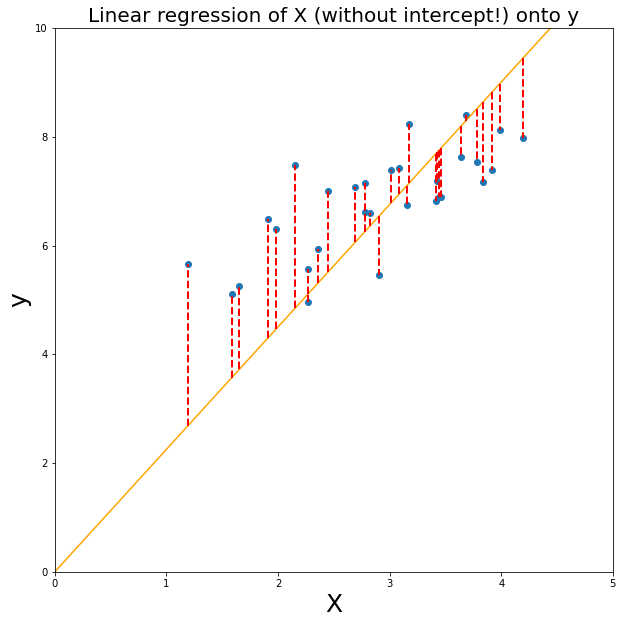

In [ ]:
X_no_icept = X_with_icept[:, 1, np.newaxis]
beta_no_icept = lstsq(X_no_icept, y, rcond=None)[0]
y_hat_no_icept = beta_no_icept * X_no_icept

plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
y_min_pred = beta_no_icept[0] * x_lim[0]
y_max_pred = beta_no_icept[0] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange')
plt.title('Linear regression of X (without intercept!) onto y', fontsize=20)

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat_no_icept[i], y[i]), 'k-', linestyle='--', c='red', lw=2)

plt.show()


A model without an intercept is "forced" to draw its line through the origin (0, 0), failing to explain much of the variance of targets (potential $y$ vectors) that have an offset/scale that is clearly far from 0 (which should be clear from the plot.)

### Summary: linear regression
Alright, hopefully this short recap on linear regression has refreshed your knowledge and understanding of important concepts such as predictors/design matrix ($X$), target ($y$), least squares, beta-parameters, intercept, $\hat{y}$, residuals, MSE, and $R^2$. 

In sum, for a linear regression analysis you need some predictors ($X$) to model some target ($y$). You perform ordinary least squares to find the beta-parameters that minimize the sum of squared residuals. To assess model fit, you can look at the mean squared error (mean of $(\hat{y} - y)^2$) or simply the squared correlation between the the predicted and the actual $y$ values ($R² = corr(\hat{y}, y)^2$). 

If you understand the above sentence, you're good to go! Before we go on to the real interesting stuff (modelling fMRI data with linear regression), let's test how well you understand linear regression so far.

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Now, you're going to implement your own linear regression on a new set of variables, but with a twist: you're going to use 5 predictors this time - we've generated the data for you already. You'll notice that the code isn't much different from when you'd implement linear regression for just a single predictor (+ intercept). In the end, you should have calculated MSE and $R^2$, which should be stored in variables named `mse_todo` and `r2_todo` respectively.

*Note, though, that it **isn't** possible to plot the data (either X, y, or y_hat) because we have more than one predictor now; X is 5-dimensional (6-dimensional if you include the intercept) - and it's impossible to plot data in 5 dimensions!*

To give you some handles on how to approach the problem, you can follow these steps:

1. Check the shape of your data: is the shape of X `(N, P)`? is the shape of y `(N, 1)`?
2. Add an intercept to the model, use: `np.hstack`;
3. Calculate the beta-parameters use `lstsq()`;
4. Evaluate the model fit by calculating the MSE and R-squared;

In [ ]:
# Here, we load the data
data = np.load('/content/drive/MyDrive/Colab Notebooks/data/ToDo.npz')
X, y = data['X'], data['y']

In [ ]:
# 1. Check the shape of X and y

X.shape
#y.shape

(1000, 5)

In [ ]:
# 2. Add the intercept (perhaps define N first, so that your code will be more clear?) using np.hstack()
N = y.size
intercept_todo = np.ones((N, 1))

tup_arr = (intercept_todo, X)
X_W_intercept = np.hstack(tup_arr)
X_W_intercept.shape


(1000, 6)

In [ ]:
# 3. Calculate the betas using lstsq()

betas = lstsq(X_W_intercept, y)
Y_hat = X_W_intercept.dot(betas[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# 4. Calculate the MSE (store it in a variable named mse_todo)

mse_todo = np.mean((y - Y_hat)**2)
print(mse_todo)

0.65633474948831


In [ ]:
# 5. Calculate R-squared  (store it in a variable named r2_todo)
sum_nm = sum((y - Y_hat) ** 2)
sum_dm = sum((y - np.mean(y))**2)
r2_todo = 1 - sum_nm / sum_dm

In [ ]:
''' Tests the ToDo above, MSE part (only hidden tests). '''

print("Your answer is tested later by hidden tests! "
      "(i.e., you can't see whether it's correct at this moment)")

assert(np.round(mse_todo, 3) == 0.656)

Your answer is tested later by hidden tests! (i.e., you can't see whether it's correct at this moment)


In [ ]:
''' Tests the ToDo above, R2-part part (only hidden tests). '''

print("Your answer is tested later by hidden tests! "
      "(i.e., you can't see whether it's correct at this moment)")

assert(np.round(r2_todo, 4) == 0.3409)


Your answer is tested later by hidden tests! (i.e., you can't see whether it's correct at this moment)


<div class='alert alert-info'>
<b>ToThink</b>
</div>

Let's check whether you understand what a particular beta-parameter means.

- Some of the betas are negative (i.e., $< 0$); what does this tell you about the effect of that particular condition/predictor? (.5 point; first text-cell)
- The intercept-parameter (i.e., $\beta_{0}$) should be about 6.6. What does this value tell us about the signal?

Write your answers in the text-cells below.

Negative betas simply state that an increase in particular predictor leads to a decrease in the target (and vice versa).

The intercept-parameter represents the 'baseline' of the signal, i.e., the average activity when there's no event (stimulus). In other words, it represents the average activity of $y$ when all predictors are held constant ($X_{j} = 0$ for every predictor $j$).

If you've finished the ToDo exercise and you're confident that you understand linear regression, you're ready to start with the fun part: applying linear regression to fMRI data!

## 2. GLM in fMRI analyses


Univariate fMRI analyses basically use the same linear regression model as we've explained above to model the activation of voxels (with some minor additions) based on some design-matrix.

### 2.1. The target ($y$)
However, compared to "regular" data, one major difference is that *the dependent variable ($y$) in fMRI analyses is timeseries data*, which means that the observations of the dependent variable (activation of voxels) vary across time. 

How does such a time-series data look like? Let's look at a (simulated) time-series from a single voxel:

In [ ]:
# import some stuff if you haven't done that already
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
%matplotlib inline

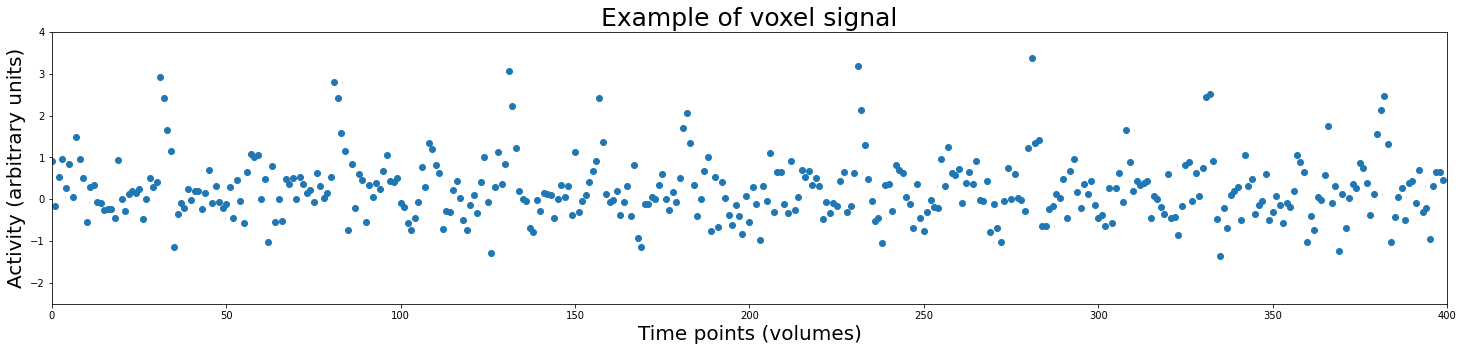

In [ ]:
voxel_signal = np.load('/content/drive/MyDrive/Colab Notebooks/data/example_voxel_signal.npy')
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal, 'o')
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (-2.5, 4)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.show()

In [ ]:
print(voxel_signal.shape)

(400,)


So, the voxel timeseries (i.e. activation over time; often called 'signal') is our dependent variable ($y$). Thus, the different time points (with corresponding activity values) make up our observations/samples!

<div class='alert alert-info'>
<b>ToThink</b>
</div>

Suppose that the TR ("time to repetition", i.e. how long it takes to measure each volume) of our acquisition was 2 seconds and we acquired 400 volumes (measurements) in our fMRI run (as you can see on the x-axis in the plot above) --
then how long did the experiment take in *seconds*? (not graded, so you don't have to write anything down!)

So, in the plot above, the data points represent the activity (in arbitrary units) of a single voxel across time (measured in volumes). This visualization of the time-series data as discrete measurements is not really intuitive. Usually, we plot the data as continuous line over time (but always remember: fMRI data is a discretely sampled signal -- *not* a continuous one). Let's plot it as a line:

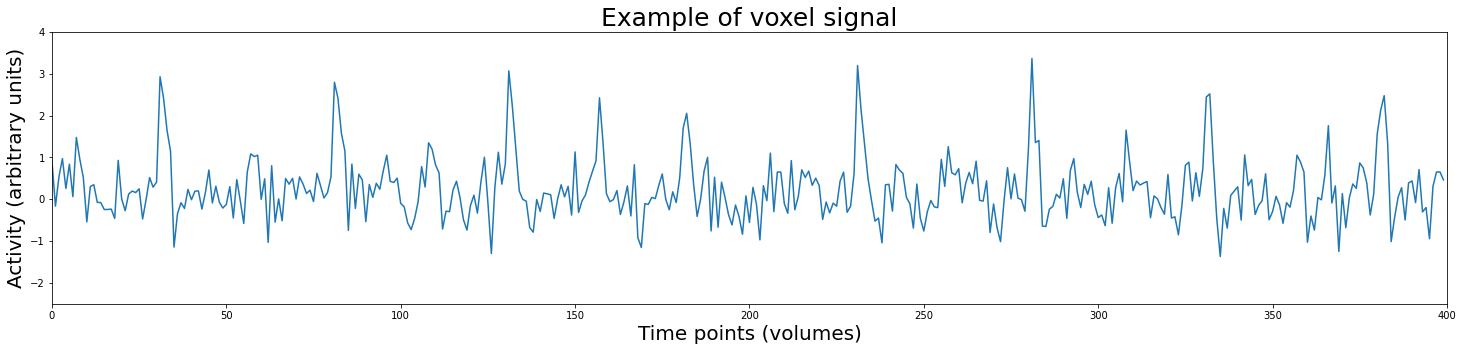

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.show()

Alright, this looks better. 

One important difference between time-series data and "regular" (non-time-series) data (as is common in most psychology research) is that *measurements in time-series data are often dependent*, while non-time-series data usually isn't.

For example, suppose that I measure the height of 100 people (i.e., non-time-series data). My measurement of person 25 is not dependent on the measurement of person 24 or person 26. In other words, it does not matter if I shuffle the measurements (i.e., the vector with 100 height measurements) for my analyses (e.g., if I wanted to do a t-test between the height of men and women in my sample). This is basically what is meant by the statement that the observations are *independent*. 

For time-series data, however, measurements are usually dependent from one observation to the next. For example, if I observe the value of a certain stock on the stock market at a particular day; suppose that I observe that the next day the stock increases slightly in value. It is then (relatively) likely that the stock the day after that again increases in value. In other words, the *measurements are dependent* (in time; another term that is used is, they are "autocorrelated"). Consequently, shuffling time-series data will usually mess up analyses.

### 2.2. The predictors ($X$), or: what should we use to model our signal ($y$)?
So, we know what our target is (the time-series data), but what do we use to model/explain our signal? Well, in most neuroimaging research, your predictors are defined by your experimental design! In other words, your predictors consist of *whatever you think influenced your signal*.

This probably sounds nonsensical, which is likely caused by the fact that we derive our independent variables (predictors) in most (observational) psychological research differently. This is because in (observational) psychological studies *both the independent variables and the dependent variables are __measured__*. In other words, our predictors are just other variables that you measured in your study. 

In neuroimaging research, however, we often derive our predictors not from measures variables but from properties of the particular experiment that we use in the MRI-scanner (or during EEG/MEG acquisiton, for that matter). In other words, we can use any property of the experiment that we believe explains our signal.

Alright, probably still sounds vague. Let's imagine a (hypothetical) experiment in which we show subjects images of either circles or squares during fMRI acquisition, as depicted in the image below:

![img](https://docs.google.com/drawings/d/e/2PACX-1vQwC4chpnzsDEzKhrKH_WHhMX7vJswY4H0pkyIxdlxI_I2GG5e8i6lsiWUO0SUk7NBgdV-vXD5PIleJ/pub?w=950&h=397)

Note that the interstimulus interval (ISI, i.e., the time between consecutive stimuli) of 50 seconds, here, is quite unrealistic; often, fMRI experiments have a much shorter ISI (e.g., around 3 seconds). Here, we will use an hypothetical experiment with an ISI of 50 seconds because that simplifies things a bit and will make figures easier to interpret.

Anyway, let's talk about what predictors we could use given our experimental paradigm. One straighforward suggestion about properties that influence our signal is that our signal is influenced by the stimuli we show the participant during the experiment. As such, we could construct a predictor that predicts some response in the signal when a stimulus (here: a square or a circle) is present, and no response when a stimulus is absent.

Fortunately, we kept track of the onsets (in seconds!) of our stimuli during the experiment:

In [ ]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710])
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760])

In other words, the first circle-stimulus was presented at 60 seconds after the scan started and the last square-stimulus was presented 710 seconds after the can started.

For now, we'll ignore the difference between square-stimuli and circle-stimuli by creating a predictor that lumps the onsets of these two types of stimuli together in one array. This predictor thus reflects the hypothesis that the signal is affected by the presence of a stimulus (regardless of whether this was a square or a circle). (Later in the tutorial, we'll explain how to *compare* the effects of different conditions.)

We'll call this predictor simply `onsets_all`:

In [ ]:
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


Now, we need to do one last thing: convert the `onsets_all` vector into a proper predictor. Right now, the variable contains only the onsets, but a predictor should be an array with the same shape as the target (here: $400 \times 1$). 

Given that our predictor should represent the hypothesis that the signal responds to the presence of a stimulus (and doesn't respond when a stimulus is absent), we can construct our predictor as a vector of all zeros, except at indices corresponding to the onsets of our stimuli.

We do this below:

In [ ]:
predictor_all = np.zeros((800, 1))

# indexing only works with an array/list of integers (we had floats), so we have to convert
# the datatype of values in onsets_all to int (using the method astype())
predictor_all[onsets_all.astype(int)] = 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (800, 1)

Contents of our predictor array:
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

However, if you look back at the plot of the voxel signal, you might notice that there is a problem in our stimulus-predictor - it seems to be on a different scale than the signal. And that's true! The signal from the voxel is measured in volumes (in total 400) while the stimulus-onsets are defined in seconds (in total 800)! 

We can solve this by "downsampling" our onsets-array to represent the onsets on the scale of our TR. (Usually, you would downsample your onsets/predictors much later in your analysis, but for the sake of the example, we'll do it here already.)

To downsample, we're simply going to keep only our "even" samples (i.e., timepoint 0, 2, 4, ... 798) using a fancy Python slice-operation:

In [ ]:
predictor_all_ds = predictor_all[0::2]
print("The downsampled predictor has now a shape of: %s" % (predictor_all_ds.shape,))

The downsampled predictor has now a shape of: (400, 1)


Awesome! Now, we have a predictor ($X$) and a target ($y$) of the same shape, so we can apply linear regression! But before we do this, let's plot the predictor and the signal in the same plot:

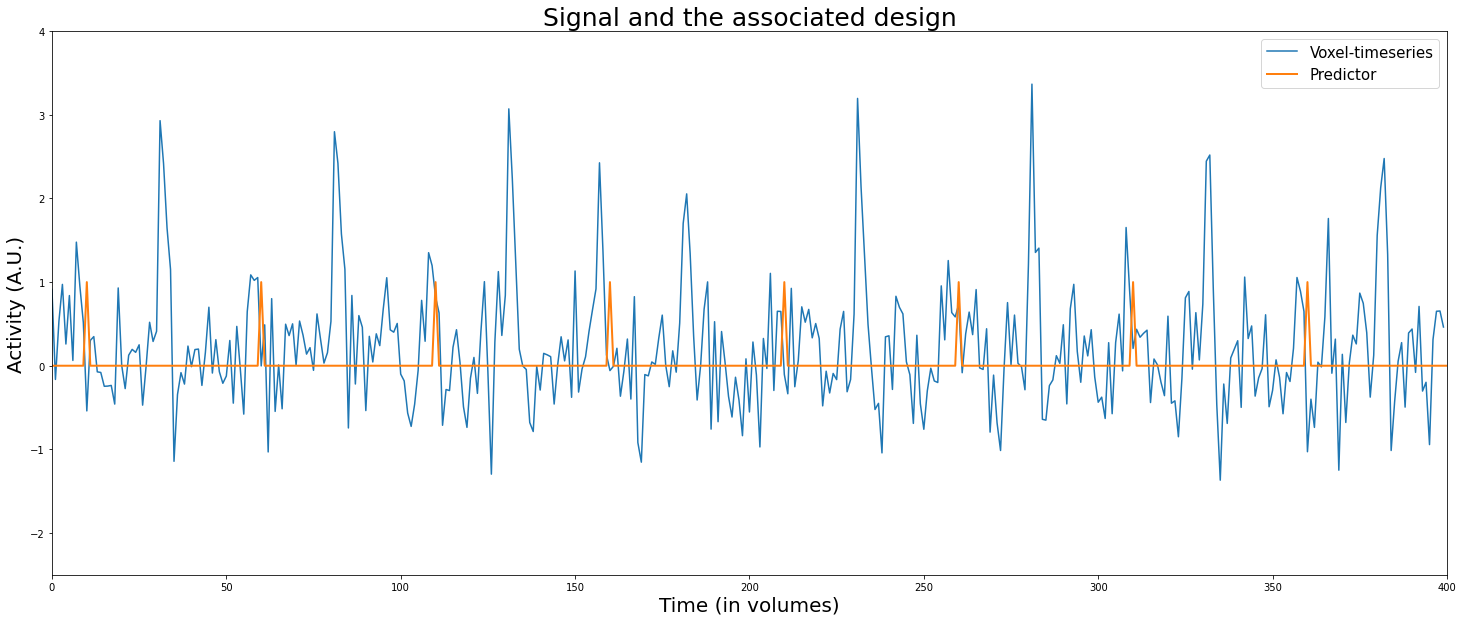

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all, lw=2)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel-timeseries', 'Predictor'], fontsize=15, loc='upper right')
plt.title("Signal and the associated design", fontsize=25)
plt.show()

Realize that plotting the predictor and the signal in the same plot is different than in the case of non-timeseries data! In non-timeseries data, we would plot a scatterplot with the target ($y$) on the y-axis and the predictor (column of $X$) on the x-axis. This is also possible for timeseries-data, but due to the fact that both the predictor and the target represent values across time, we can plot them "on the same axis". The nice thing about this is that for timeseries data, we can plot as many predictors in the same plot as we want!

Anyway, in the above plot the orange line represents our predictor, which represents the hypothesis that the activity of the signal (the blue line) is significantly different when a stimulus is presented (the peaks in the orange line) than when no stimulus is presented (the flat parts of the orange line). 

Or, phrased differently (but mathematically equivalent): what is the effect of a unit increase in the predictor ($X = 0 = no\ stimulus \rightarrow X = 1 = stimulus$) on the target (the signal)? We can answer this question with linear regression of course!

### 2.3. Regression on fMRI data & interpretation parameters
As said before, applying regression analysis on fMRI data is done largely the same as on regular non-timeseries data. As always, we first need to stack an intercept. 

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Stack an intercept to the predictor (`predictor_all_ds`) and store the result in a variable named `X_simple`. Then, run linear regression on the signal (`voxel_signal`) and save the beta-parameters in a new variable named `betas_simple`. Finally, calculate MSE and $R^ 2$ for this model and store these values in new variables named `mse_simple` and `r2_simple`. 

In [ ]:
# Implement the ToDo here
intercept_voxel = np.ones((voxel_signal.size, 1))
voxel_tup = (intercept_voxel, predictor_all_ds)
X_simple = np.hstack(voxel_tup) #created our design matrix 
betas_simple = lstsq(X_simple, voxel_signal, rcond=None)[0]
print(betas_simple)
y_hat_simple = X_simple.dot(betas_simple)
mse_simple = np.mean((voxel_signal - y_hat_simple)**2)
r2_simple = 1 - (sum((voxel_signal - y_hat_simple)**2)/sum((voxel_signal - np.mean(voxel_signal))**2))
print(mse_simple, r2_simple)

[0.22906638 0.29013025]
0.5343768571408877 0.0060124370964088625


If you've done the ToDo correctly, you should have found the the following beta-parameters: 0.229 for the intercept and 0.290 for our stimulus-predictor. This means that our linear regression model for that voxel is as follows:

\begin{align}
y_{voxel} = \beta_{intercept} + X_{stim}\beta_{stim} + \epsilon = 0.229 + X_{stim}0.290 + \epsilon
\end{align}

This simply means that for a unit increase in $X$ (i.e., $X = 0 \rightarrow X = 1$), $y$ increases with 0.290. In other words, on average the signal is 0.290 higher when a stimulus is present compared to when a stimulus is absent!

To aid interpretation, let's plot the signal ($y$) and the predicted signal ($\hat{y} = \beta X$) in the same plot.

[0.22906638 0.29013025]


Text(0.5, 1.0, 'Signal and predicted signal')

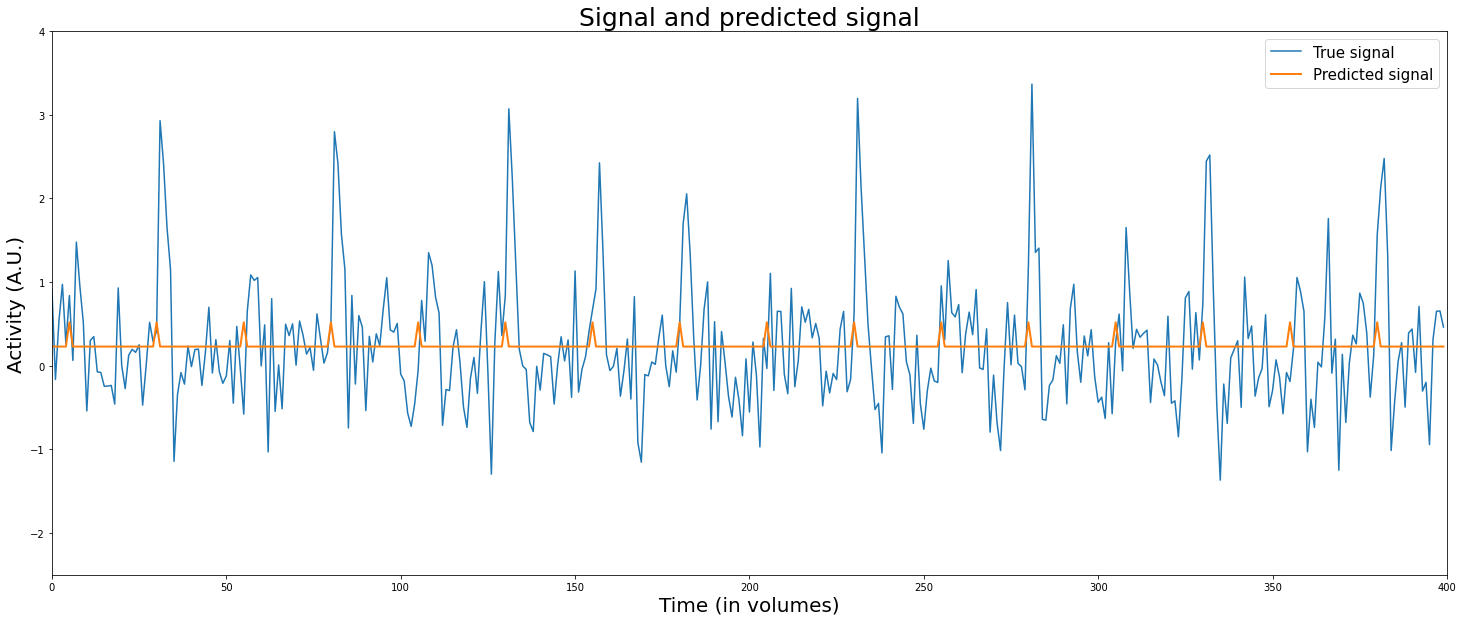

In [ ]:
des = np.hstack((np.ones((400, 1)), predictor_all_ds))
betas_simple = np.linalg.lstsq(des, voxel_signal, rcond=None)[0]
print(betas_simple)
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(des.dot(betas_simple), lw=2)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(['True signal', 'Predicted signal'], loc='upper right', fontsize=15)
plt.title("Signal and predicted signal", fontsize=25)

The orange line represents the predicted signal, which is based on the original predictor ($X$) multiplied (or "scaled") by the associated beta-parameters ($\beta$). Graphically, you can interpret the beta-parameter of the stimulus-predictor ($\beta_{stim}$) as the maximum height of the peaks in the orange line\* and the beta-parameter of the intercept ($\beta_{intercept}$) as the difference from the flat portion of the orange line and 0 (i.e. the "offset" of the signal).

---
\* This holds true only when the maximum value of the original predictor is 1 (which is true in our case)

Let's zoom in on a portion of the data to show this:

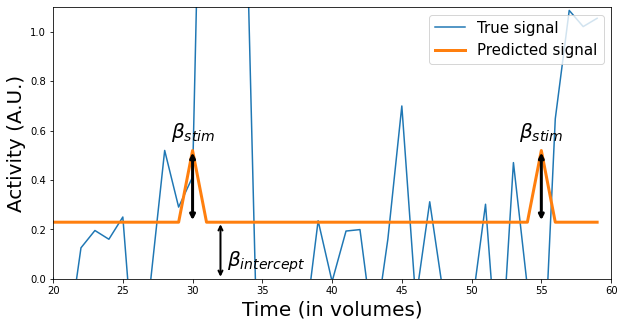

In [ ]:
des = np.hstack((np.ones((400, 1)), predictor_all_ds))
betas_simple = np.linalg.lstsq(des, voxel_signal, rcond=None)[0]
des = des[20:60, :]

plt.figure(figsize=(10, 5))
plt.plot(voxel_signal[20:60])
plt.plot(des.dot(betas_simple), lw=3)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlim(0, 40)
plt.ylim(0, 1.1)
plt.annotate('', xy=(10, betas_simple[0]), xytext=(10, betas_simple[1] + betas_simple[0]),
             arrowprops=dict(arrowstyle='<->', lw=3))
plt.text(10, betas_simple.sum() + 0.05, r'$\beta_{stim}$', horizontalalignment='center', fontsize=20)

plt.annotate('', xy=(35, betas_simple[0]), xytext=(35, betas_simple[1] + betas_simple[0]),
             arrowprops=dict(arrowstyle='<->', lw=3))
plt.text(35, betas_simple.sum() + 0.05, r'$\beta_{stim}$', horizontalalignment='center', fontsize=20)

plt.annotate('', xy=(12, 0), xytext=(12, betas_simple[0]),
             arrowprops=dict(arrowstyle='<->', lw=2))
plt.text(12.5, 0.05, r'$\beta_{intercept}$', fontsize=20)

plt.legend(['True signal', 'Predicted signal'], fontsize=15, loc='upper right')
plt.xticks(np.arange(0, 41, 5), np.arange(20, 61, 5));

Anyway, there seems to be an effect on voxel activity when we show a stimulus (increase of 0.290 in the signal on average), but (if you've done the ToDo correctly) you've also seen that the model fit is quite bad ($R^2 = 0.006$, about 0.6% explained variance) ...

What is happening here? Is our voxel just super noisy? Or is something wrong with our model? We'll talk about this in the next section!

### 2.4. Using the BOLD-response in GLM models
Let's go back to our original idea behind the predictor we created. We assumed that in order to model activity in response to our stimuli, our predictor should capture an increase/decrease in activity *at the moment of stimulus onset*. But this is, given our knowledge of the BOLD-response, kind of unrealistic to assume: it is impossible to measure instantaneous changes in neural activity in response to stimuli or tasks with fMRI, *because the BOLD-response is quite slow and usually peaks around 5-7 seconds **after** the 'true' neuronal activity (i.e. at cellular level)*. 

In the above model, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as a response to an instantaneous stimulus event. 

You can imagine that if you incorporate this knowledge about the BOLD-response into our model, the fit will likely get better! In this section, we'll investigate different ways to incorporate knowledge of the BOLD-response in our predictors.

#### 2.4.1. The canonical HRF
The easiest and most often-used approach to incorporating knowledge about the BOLD-response in univariate analyses of fMRI data is to assume that each voxel responds to a stimulus in a fixed way. In other words, that voxels always respond (activate/deactivate) to a stimulus in the same manner. This is known as using a "canonical haemodynamic response function (HRF)". Basically, an HRF is a formalization of how we think the a voxel is going to respond to a stimulus. A *canonical* HRF is the implementation of an HRF in which you use the same HRF for each voxel, participant, and condition. There are other implementations of HRFs (apart from the canonical), in which you can adjust the exact shape of the HRF based on the data you have; examples of these HRFs are *temporal basis sets* and *finite impulse reponse models* (FIR), which we'll discuss later.

There are different types of (canonical) HRFs; each models the assumed shape of the BOLD-response slightly differently. For this course, we'll use the most often used canonical HRF: the double-gamma HRF (which is a combination of different gamma functions).

The double-gamma HRF looks like this:

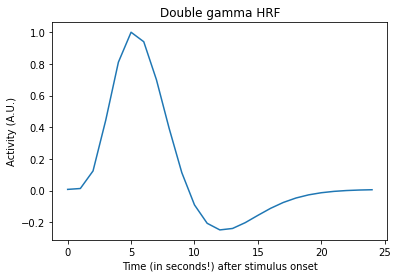

In [ ]:
def double_gamma(x, lag=6, a2=12, b1=0.9, b2=0.9, c=0.35, scale=True):

    a1 = lag
    d1 = a1 * b1 
    d2 = a2 * b2 
    hrf = np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])
    
    if scale:
        hrf = (1 - hrf.min()) * (hrf - hrf.min()) / (hrf.max() - hrf.min()) + hrf.min()
    return hrf


def single_gamma(x, lag=6, b=0.9, scale=True):
    b = b 
    a = lag 
    d = a * b
    hrf = (x/d)**a * np.exp(-(x-d)/b)
    
    if scale:
        hrf = (1 - hrf.min()) * (hrf - hrf.min()) / (hrf.max() - hrf.min()) + hrf.min()

    return hrf


# Time-points refers to the desired length of the array
# representing the HRF. Does not matter too much (as long
# as it incorporates the full shape of the HRF, here: 25 seconds)
time_points = np.arange(25)  
dg_hrf = double_gamma(time_points, lag=6)
plt.plot(dg_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset')
plt.ylabel('Activity (A.U.)')
plt.title('Double gamma HRF');

Note that the output of the HRF is defined in seconds! That is, it's at the same scale as our stimulus-predictor (the one that's not yet downsampled).

But how should we incorporate this HRF into our model? Traditionally, this is done using a mathematical operation called **convolution**. Basically, it "slides" the HRF across our 0-1 coded stimulus-vector from left to right and elementwise multiplies the HRF with the stimulus-vector. This is often denoted as:

\begin{align}
X_{conv} = \mathrm{HRF} * X_{original}
\end{align}

in which $*$ is the symbol for convolution, $X_{original}$ is the original stimulus-vector, and $X_{conv}$ the result of the convolution.

Let's plot an example to make it clearer. Suppose we have an onset-vector of length 100 (i.e., the experiment was 100 seconds long) with three stimulus presentations: at $t = 10$, $t = 40$, and $t = 70$. The stimulus-vector (upper plot), double-gamma HRF (right plot), and the result of the convolution of the stimulus-vector and the HRF (lower plot) looks as follows:

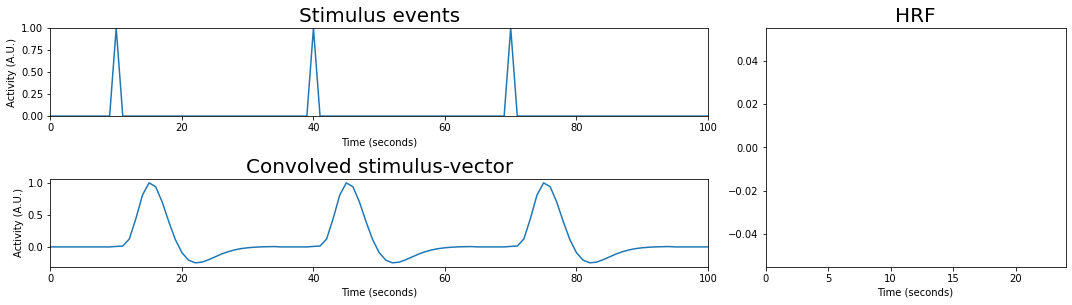

In [ ]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(400)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)')
plt.xlabel('Time (seconds)')
plt.title('Stimulus events', fontsize=20)

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot( )
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)")

convolved_stim_vector = np.convolve(random_stim_vector, dg_hrf, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)')
plt.xlabel('Time (seconds)')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

The result -- the convolved stimulus-vector -- is basically the output of a the multiplication of the HRF and the stimulus-events when you would "slide" the HRF across the stimulus vector. As you can see, the convolved stimulus-vector correctly shows the to-be-expected lag and shape of the BOLD-response! Given that this new predictor incorporates this knowledge of the to-be expected response, it will probably model the activity of our voxel way better. Note that the temporal resolution of your convolved regressor is necessary limited by the resolution of your data (i.e. the TR of your fMRI acquisition). That's why the convolved regressor doesn't look as "smooth" as the HRF. 

As you can see in the code for the plot above, numpy provides us with a function to convolve two arrays:

```python
np.convolve(array_1, array_2)
```

Now, we can convolve the HRF with out stimulus-predictor. Importantly, we want to do this convolution operation in the resolution of our onsets (here: seconds), not in the resolution of our signal (TR) (the reason for this is explained clearly in Jeanette Mumford's [video on the HRF](https://www.youtube.com/watch?v=5JNX34gYG7Q).)
Therefore, we need to perform the convolution on the variable `predictor_all` (*not* the downsampled variable: `predictor_all_ds`)!

We'll do this below (we'll reuse the `dg_hrf` variable defined earlier):

In [ ]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), dg_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also need to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (824,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


It's a bit of a hassle (squeezing out the singleton axis, trimming, adding the axis back ...), but now we have a predictor which includes information about the expected HRF!

Let's look at the predictor before and after convolution in the same plot:

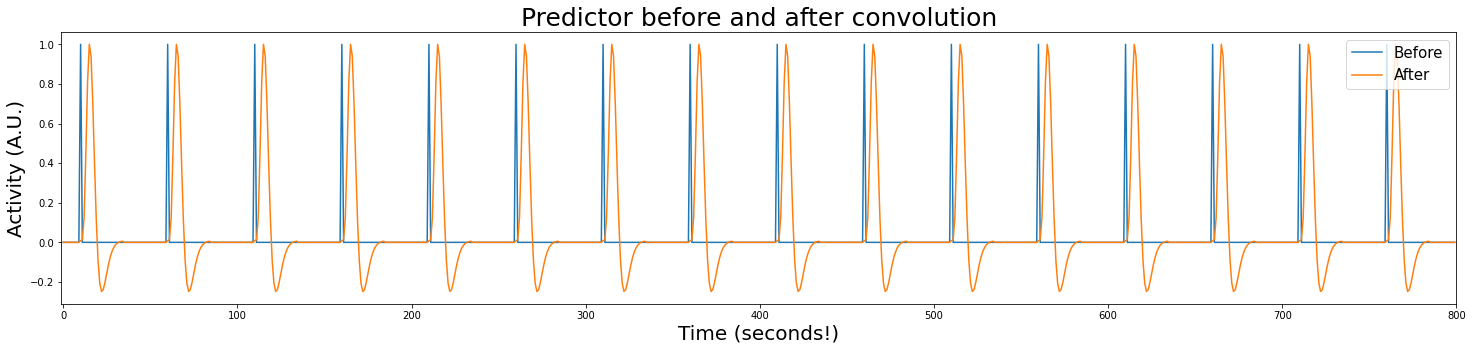

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.show()

Great! Our predictor now includes the expected 'lag' and shape of the HRF, and we can start analyzing our signal with our new convolved predictor! But before we'll do this, there is one more concept that we'll demonstrate. Remember the concept of **linear scaling** of the BOLD-response? This property of the BOLD-response states that it will linearly scale with the input it is given.

Let's see how that works:

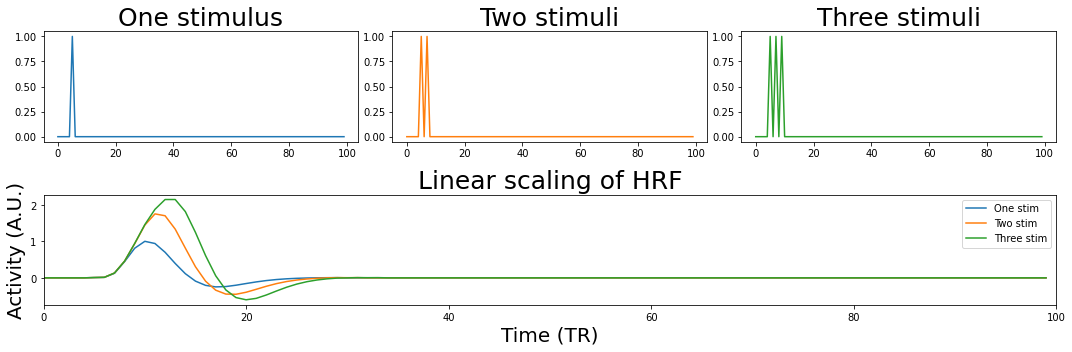

In [ ]:
plt.figure(figsize=(15, 5))

one_stim = np.zeros(100)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, dg_hrf)[:100]
two_stim = np.zeros(100)
two_stim[[5, 7]] = 1
two_stim_conv = np.convolve(two_stim, dg_hrf)[:100]
three_stim = np.zeros(100)
three_stim[[5, 7, 9]] = 1
three_stim_conv = np.convolve(three_stim, dg_hrf)[:100]

plt.subplot2grid((2, 3), (0, 0))
plt.plot(one_stim)
plt.title("One stimulus", fontsize=25)

plt.subplot2grid((2, 3), (0, 1))
plt.plot(two_stim, c='tab:orange')
plt.title("Two stimuli", fontsize=25)

plt.subplot2grid((2, 3), (0, 2))
plt.plot(three_stim, c='tab:green')
plt.title("Three stimuli", fontsize=25)

plt.subplot2grid((2, 3), (1, 0), colspan=3)

plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

Also, in our random stimulus-vector above (and also in the example we showed earlier) we assumed that each image was only showed briefly (i.e. we only modelled the onset) - but what if a stimulus (or task) may take longer, say, 15 seconds? Let's see what happens.

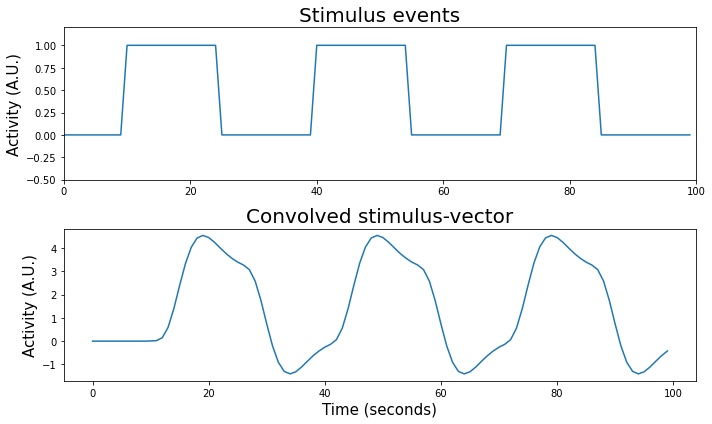

In [ ]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)

plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=15)

plt.title('Stimulus events', fontsize=20)

convolved_stim_vector2 = np.convolve(random_stim_vector2, dg_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)

plt.tight_layout()
plt.show()

As you can see, convolution takes care to model the shape of the BOLD-response according to how long you specify the stimulus to take! 

<div class='alert alert-info'>
<b>ToThink</b>
</div>

Given the properties of the BOLD-response (and assuming linear-time invariance is not violated), would you expect the same or a different BOLD-response in response to 3 consecutive stimuli (of the same condition) of half a second second each (which follow each other immediately, i.e. without interstimulus interval) versus 1 stimulus of 1.5 seconds? Why? (Write your answer in the text-cell below)

Because the BOLD-response is so slow, it cannot distinguish between short consecutive stimuli and one longer stimulus (which is evident by the fact that after convolution of these two hypothetical stimulus-vectors, they look identical).

Actually, convolution can model *any* sequence of stimulus events, even stimuli with random onsets - just look at the plot below!

(you can execute this cell below multiple times to see different random regressor shapes!)

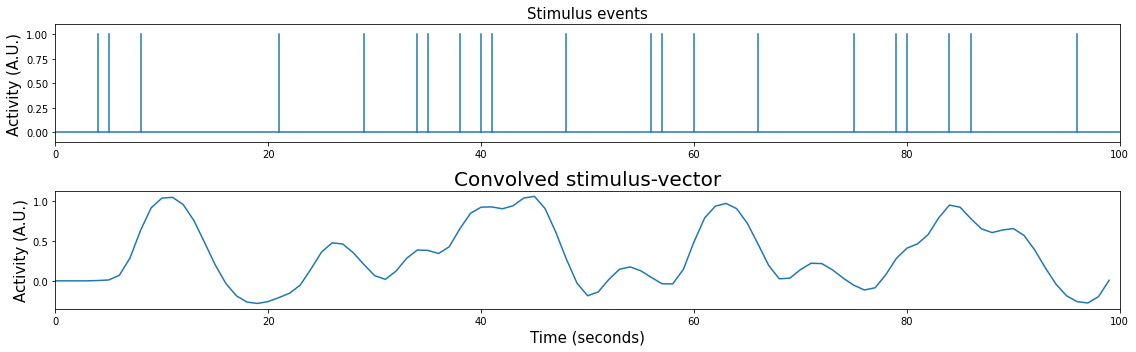

In [ ]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(16, 5))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), 'k-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Stimulus events', fontsize=15)

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, dg_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)

plt.tight_layout()
plt.show()

So, in summary, convolving the stimulus-onsets (and their duration) with the HRF gives us (probably) a better predictor of the voxel signal than just the stimulus-onset, because (1) it models the lag of the BOLD-response and (2) models the shape of the BOLD-response (accounting for the linear scaling principle). 

Now, we're *almost* ready to start analyzing our signal with the convolved predictor! The problem, at this moment, however is that the convolved predictor and the signal are on different scales!

In [ ]:
print("Shape of convolved predictor: %s" % (predictor_conv.shape,))
print("Shape of signal: %s" % (voxel_signal.shape,))

Shape of convolved predictor: (800, 1)
Shape of signal: (400,)


To fix this, we need to downsample the predictor again, like we did earlier:

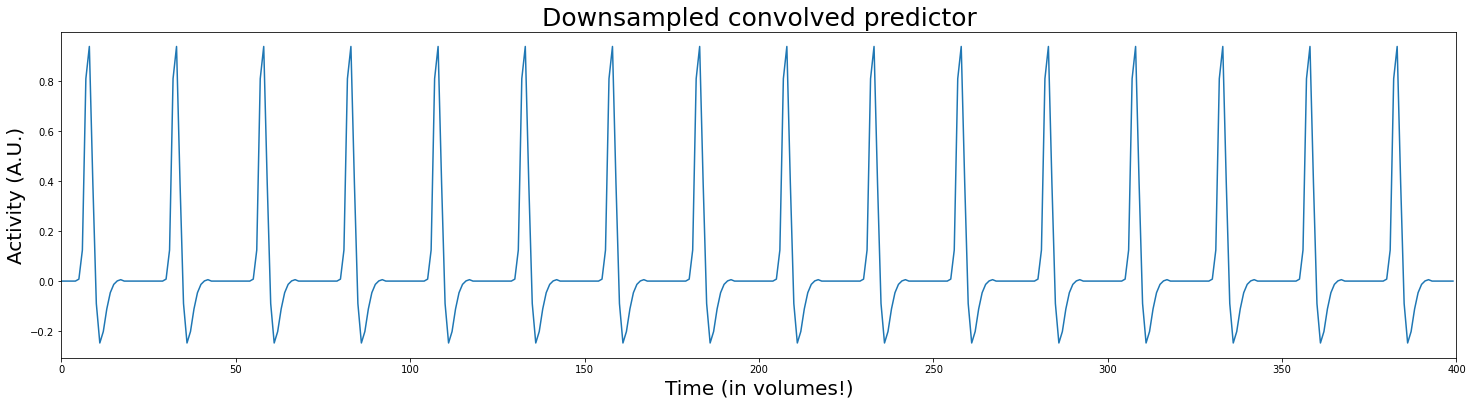

Shape of downsampled predictor is now: (400, 1)


In [ ]:
predictor_conv_ds = predictor_conv[::2]
plt.figure(figsize=(25, 6))
plt.plot(predictor_conv_ds)
plt.xlim(x_lim)
plt.title("Downsampled convolved predictor", fontsize=25)
plt.xlabel("Time (in volumes!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.show()

print("Shape of downsampled predictor is now: %s" % (predictor_all_ds.shape,))

Finally ... we're ready to see whether the HRF-based predictor *actually* models our original voxel signal (`voxel_signal`, from earlier in the tutorial) more accurately! Let's create a proper design-matrix ($X$) by stacking an intercept with the stimulus-regressor, perform the regression analysis, and check out the results (by plotting the predicted signal against the true signal). For comparison, we'll also plot the original (unconvolved) model as well!

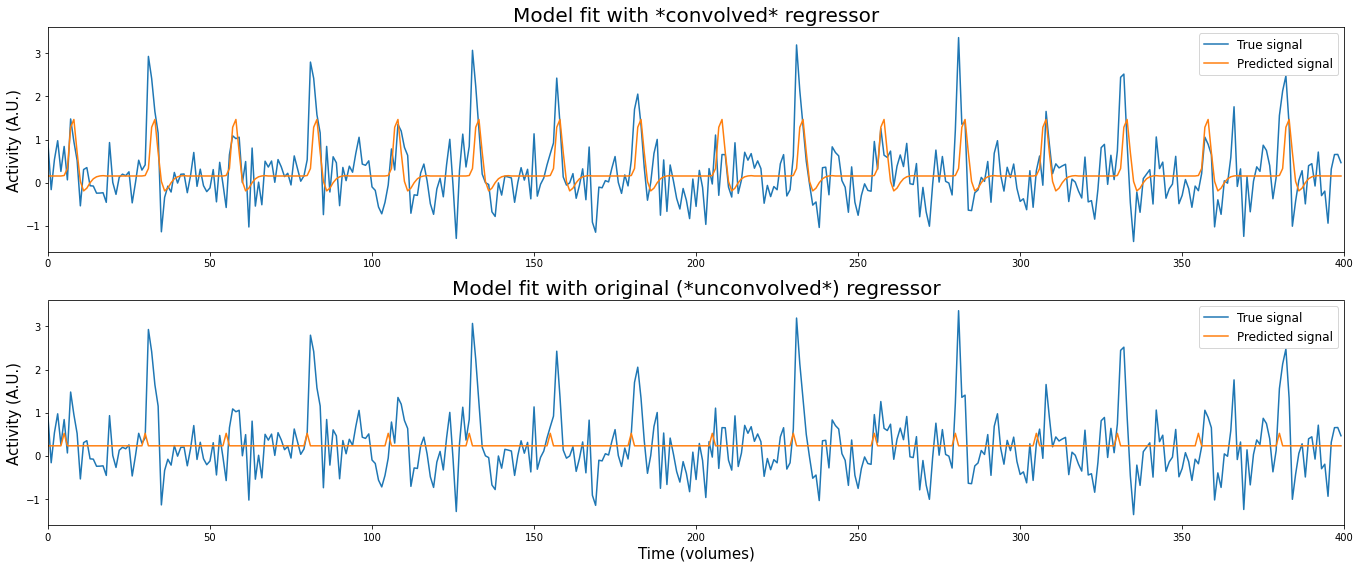

In [ ]:
intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = lstsq(X_conv, voxel_signal, rcond=None)[0]

plt.figure(figsize=(19, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv.dot(betas_conv))
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=15)
plt.title("Model fit with *convolved* regressor", fontsize=20)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
plt.plot(X_simple.dot(betas_simple))
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=15)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=20)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=15)
plt.tight_layout()
plt.show()

Wow, that looks much better, right! First, let's inspect the beta-parameters:

In [ ]:
print('The beta-parameter of our stimulus-predictor is now: %.3f' % betas_conv[1])
print('... which is %.3f times larger than the beta of our original '
      'beta (based on the unconvolved predictors)!' % (betas_conv[1] / 0.290))

The beta-parameter of our stimulus-predictor is now: 1.396
... which is 4.814 times larger than the beta of our original beta (based on the unconvolved predictors)!


Like we did before, we'll zoom in and show you how the estimated beta-parameters relate tho the data:

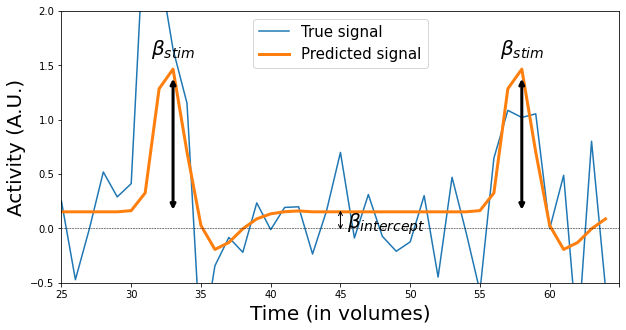

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(voxel_signal[25:65])
plt.plot(X_conv[25:65, :].dot(betas_conv), lw=3)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlim(0, 40)
plt.ylim(-.5, 2)
plt.annotate('', xy=(8, betas_conv[0]), xytext=(8, betas_conv[1]),
             arrowprops=dict(arrowstyle='<->', lw=3))
plt.text(8, betas_conv.sum() + 0.05, r'$\beta_{stim}$', horizontalalignment='center', fontsize=20)

plt.annotate('', xy=(33, betas_conv[0]), xytext=(33, betas_conv[1]),
             arrowprops=dict(arrowstyle='<->', lw=3))
plt.text(33, betas_conv.sum() + 0.05, r'$\beta_{stim}$', horizontalalignment='center', fontsize=20)

plt.annotate('', xy=(20, -0.03), xytext=(20, betas_conv[0] + 0.03),
             arrowprops=dict(arrowstyle='<->', lw=1))
plt.text(20.5, 0.0, r'$\beta_{intercept}$', fontsize=20)
plt.axhline(0, ls='--', c='k', lw=0.5)

plt.legend(['True signal', 'Predicted signal'], fontsize=15, loc='upper center')
plt.xticks(np.arange(0, 41, 5), np.arange(25, 65, 5))
plt.show()

Alright, so we seem to measure a way larger effect of our stimulus on the voxel activity, but is the model fit actually also better? Let's find out.

In [ ]:
y_hat_conv = X_conv.dot(betas_conv)
des_tmp = np.hstack((np.ones((400, 1)), predictor_all_ds))
y_hat_orig = des_tmp.dot(lstsq(des_tmp, voxel_signal, rcond=None)[0])

MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_orig = ((y_hat_orig - voxel_signal) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f" %
     (MSE_conv, MSE_orig))

R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_orig = 1 - (np.sum((voxel_signal - y_hat_orig) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f" % 
     (R2_conv, R2_orig))

MSE of model with convolution is 0.402 while the MSE of the model without convolution is 0.534
R-squared of model with convolution is 0.25208 and without convolution it is 0.00601


From the model fit metrics above, we can safely conclude that (at least for this voxel), a design ($X$) in which we include information about the expected lag/shape of the HRF is *way* better than a 'HRF-naive' design (i.e. an unconvolved design). 

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

So far, our examples were based on the stimulus-onsets of the two conditions (circles and squares) lumped together. This tested the hypothesis of our voxel responded to *any kind* of stimulus -- regardless of the condition (squares/circles) of the stimulus. Usually, however, you want to estimate the betas for each condition separately (i.e., how much each condition on average activates a voxel) and test the influence of each condition on the voxel separately (but estimated in the same model)! This is what you're going to do in this ToDo.

We provide you with the predictors for circles (`predictor_circles`) and for squares (`predictor_squares`) below. You have to do the following:

- convolve each predictor with the double-gamma HRF (use `dg_hrf`) separately (don't forget to squeeze, trim, and add the axis back)
- downsample the convolved predictors
- stack an intercept and the two predictors **in a single design-matrix** ($X$) -- use `np.hstack((intercept, pred1, pred2))` for this
- calculate the beta-parameters (estimated in a single model!)
- calculate MSE (store this in the variable `mse_new`) and $R^2$ (store this in the variable `r2_new`)


array([0.15291487, 1.8071736 , 0.9849534 ])

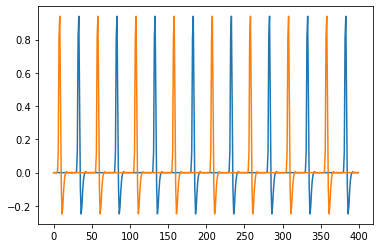

In [ ]:
predictor_circles = np.zeros((800, 1))
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros((800, 1))
predictor_squares[onsets_squares] = 1

# Implement your ToDo below

## convolce, squeeze, trim and add the axis back
pred_circ_conv = np.convolve(predictor_circles.squeeze(), dg_hrf, 'full')[: predictor_circles.size]
pred_circ_conv = pred_circ_conv[:, np.newaxis]
pred_squar_conv = np.convolve(predictor_squares.squeeze(), dg_hrf, 'full')[: predictor_squares.size]
pred_squar_conv = pred_squar_conv[:, np.newaxis]

##downsample
pred_circ_conv_ds = pred_circ_conv[::2]
pred_squar_conv_ds = pred_squar_conv[::2]

intercept = np.ones((pred_squar_conv_ds.size, 1))
X_new = np.hstack((intercept, pred_circ_conv_ds, pred_squar_conv_ds))
#X_cr = np.hstack((intercept, pred_squar_conv_ds))

plt.plot(pred_circ_conv_ds)
plt.plot(pred_squar_conv_ds)

# X_new = 
# print(X_new)
# X_new = ...
b_new = lstsq(X_new, voxel_signal, rcond=None)[0]
y_hat_new = X_new.dot(b_new)
mse_new =((y_hat_new - voxel_signal) ** 2).mean()
r2_new = 1 - (np.sum((voxel_signal - y_hat_new) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

b_new

[0.15291487 1.8071736  0.9849534 ]


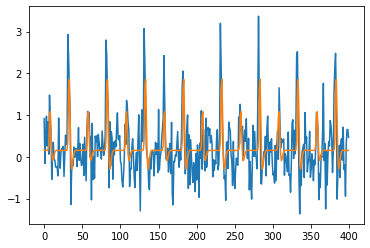

In [ ]:
print(b_new)
plt.plot(voxel_signal)
plt.plot(y_hat_new)

<div class='alert alert-info'>
<b>ToThink</b>
</div>

If you've done the above ToDo correctly, you should have found that the model fit of the design-matrix with the circles and squares predictors separately (as you did in the ToDo) leads to a (somewhat) better model fit (lower MSE/higher $R^2$) than the design-matrix with the conditions lumped together in a single predictor (as we did earlier).

Argue why you think this is the case here.

Because with separate predictors, the model can assign different effects to the two predictors. If the two conditions would in fact have a different effect on the voxel, then this would be impossible to model in the lumped-together scenario, because this model can only explain a "common" effect of the conditions.

#### 2.4.2. Temporal basis functions
Most studies use a canonical HRF to convolve with their predictors. However, remember that using a canonical HRF assumes that the particular shape of that HRF will be appropriate for each voxel, each condition, and each subject in your study. This is quite a strong assumption. In fact, studies have shown that the exact shape of the HRF often differs between voxels, conditions, and subjects (as is explained in detail by the [video on basis sets](https://www.youtube.com/watch?v=YfeMIcDWwko&index=21&list=PLcvMDPDk-dSmTBejANv7kY2mFo1ni_gkA) by Tor Wager).

In fact, this might also be the case in our data! If you've done the ToDo correctly, you might have seen that the predictions ($\hat{y}$) seem to "peak" too late for the circle-stimuli... In fact, let's plot the data ($y$) and the prediction based on the circles-predictor ($X_{circles}\beta_{1}$) and the prediction based on the squares-predictor ($X_{squares}\beta_{2}$) separately:

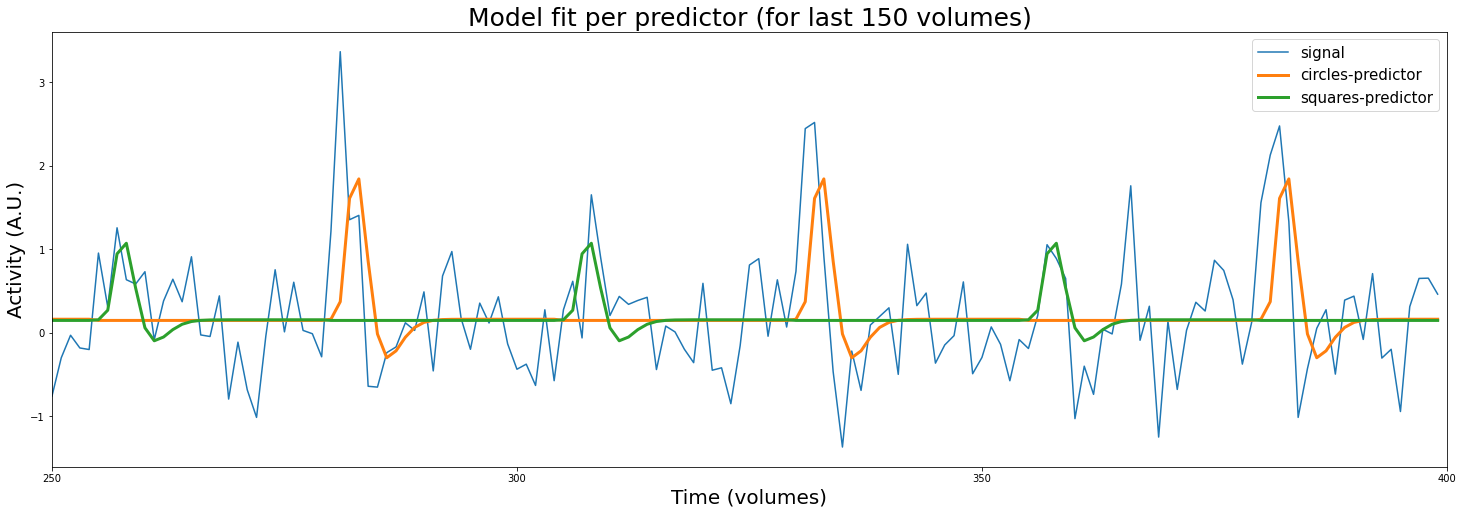

In [ ]:
dg_hrf = double_gamma(np.arange(50))    
pred_circ_conv = np.convolve(predictor_circles.squeeze(), dg_hrf)[:800][:, np.newaxis]
pred_squar_conv = np.convolve(predictor_squares.squeeze(), dg_hrf)[:800][:, np.newaxis]
X_new = np.hstack((np.ones((800, 1)), pred_circ_conv, pred_squar_conv))
X_new = X_new[::2, :]
b_new = np.linalg.lstsq(X_new, voxel_signal, rcond=None)[0]
circ_hat = b_new[0] + b_new[1] * X_new[:, 1]
squar_hat = b_new[0] + b_new[2] * X_new[:, 2]
y_hat_new = X_new.dot(b_new)
plt.figure(figsize=(25, 8))
plt.plot(voxel_signal[250:])
plt.plot(circ_hat[250:], lw=3)
plt.plot(squar_hat[250:], lw=3)
plt.xticks(np.arange(0, 151, 50), np.arange(250, 401, 50))
plt.xlim(0, 150)
plt.xlabel("Time (volumes)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit per predictor (for last 150 volumes)", fontsize=25)
plt.legend(['signal', 'circles-predictor', 'squares-predictor'], fontsize=15)

So, what should be do about this? Well, one solution is to use *temporal basis functions* (also called *temporal basis sets*). Temporal basis functions model the HRF as *a combination of (haemodynamic response) functions*. 

In practice, this amounts to convolving your predictor with not one, but multiple HRFs. This results in multiple predictors per stimulus-condition! Each HRF measures a "part" (or property) of the total HRF. Together, these predictors aim to estimate the complete HRF for a given stimulus-vector (condition). 

We're going to use *single-gamma basis functions* as an example of a temporal basis set (but there are other sets, like the *sine basis set* and *finite impulse response* set). In this particular basis set, the original single-gamma HRF is used in combination with its first derivative (often called the 'temporal derivative') and its second derivative (the derivative of the derivative, so to say; often called the 'dispersion derivative'). 

Suppose we have only one stimulus condition. Then, the signal ($y$) is not modelled by only one convolved predictor ($\beta X$) but by three predictors: a predictor convolved with the original HRF ($X_{orig}\beta_{1}$), a predictor convolved with the temporal derivative of the HRF ($X_{temp}\beta_{2}$), and a predictor convolved with the dispersion derivative of the HRF ($X_{disp}\beta_{3}$). Formally:

\begin{align}
y = \beta_{0} + X_{orig}\beta_{1} + X_{temp}\beta_{2} + X_{disp}\beta_{3} + \epsilon
\end{align}

Alright, but how do we compute these derivatives and how do they look like? Well, the derivatives are easily computed using the `np.diff` function, which takes an array and returns the value-by-value difference (i.e., for array $x$, it returns for each value $x_{i}$ the value $x_{i} - x_{i+1}$). 

Let's calculate and plot the first (temporal) derivative and second (dispersion) derivative:

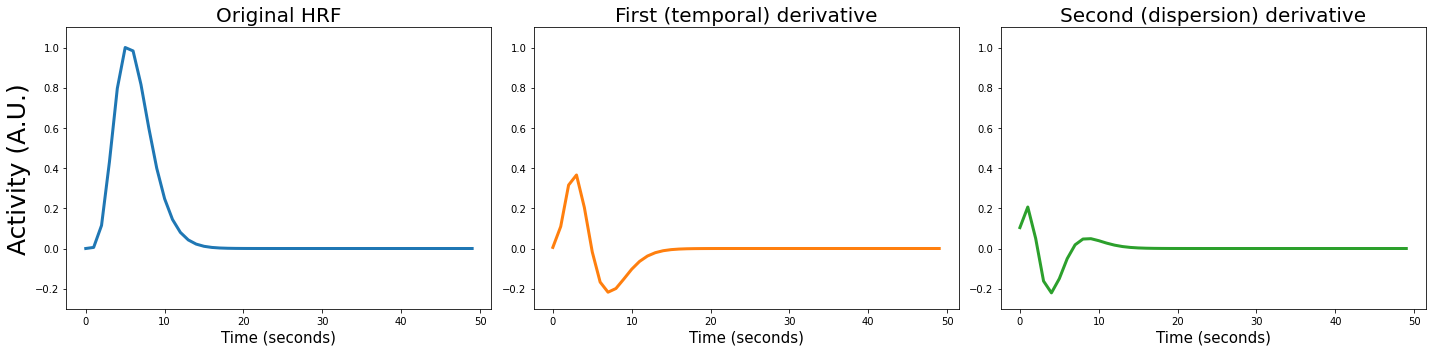

In [ ]:
sg_hrf = single_gamma(np.arange(0, 50))
sg_hrf_temp = np.diff(sg_hrf)
sg_hrf_disp = np.diff(sg_hrf_temp)

# Differentiation trims of one value, so we need to add that back
sg_hrf_temp = np.append(sg_hrf_temp, 0)
sg_hrf_disp = np.append(sg_hrf_disp, [0, 0])

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(sg_hrf, lw=3)
plt.ylim(-0.3, 1.1)
plt.ylabel("Activity (A.U.)", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=15)
plt.title("Original HRF", fontsize=20)

plt.subplot(1, 3, 2)
plt.plot(sg_hrf_temp, c='tab:orange', lw=3)
plt.ylim(-0.3, 1.1)
plt.xlabel("Time (seconds)", fontsize=15)
plt.title("First (temporal) derivative", fontsize=20)

plt.subplot(1, 3, 3)
plt.plot(sg_hrf_disp, c='tab:green', lw=3)
plt.ylim(-0.3, 1.1)
plt.xlabel("Time (seconds)", fontsize=15)
plt.title("Second (dispersion) derivative", fontsize=20)

plt.tight_layout()
plt.show()

The cool thing about this single-gamma basis set is that the derivatives can (to a certain extent) correct for slight deviations in the lag and shape of the HRF based on the data! Specifically, the first (temporal) derivative can correct for slight differences in lag (compared to the canonical single-gamma HRF) and the second (dispersoin) derivative can correct for slight difference in the width (or "dispersion") of the HRF (compared to the canonical single-gamma HRF). 

"How does this 'correction' work, then?", you might ask. Well, think about it this way: the original (canonical) HRF measures the increase/decrease -- or amplitude -- of the BOLD-response. In a similar way, the temporal derivative measures the *onset* -- or lag -- of the BOLD-response. And finally the dispersion derivative measures the *width* of the BOLD-response. 

When we use our three predictors (one convolved with the canonical HRF, one with the temporal derivative, and one with the dispersion derivative) in a linear regression model, the model will assign each predictor (each part of the HRF) a beta-weight, as you know. These beta-weights are chosen such that model the data -- some response of the voxel to a stimulus -- as well as possible. Basically, assigning a (relatively) high beta-weight to the predictor convolved with the temporal derivative will "shift" the HRF (increases/decreases the onset of the HRF). Assigning a (relatively) high beta-weight to the predictor convolved with the dispersion derivative will increase/decrease the width of the HRF.

Alright, let's visualize this. Suppose we have a voxel that we know does not conform to the specific assumptions about lag (onset) and width of the canonical (single-gamma) HRF. We'll show below that it suboptimally explains this voxel:

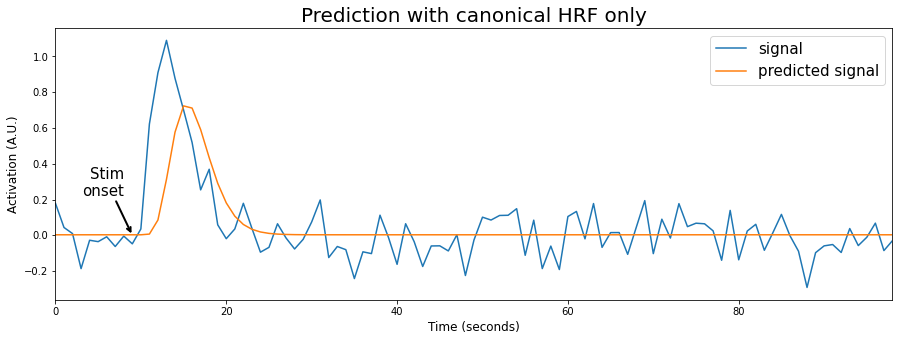

In [ ]:
example_data = np.load('data/voxel_basissets_example.npz')
example_vox, onset_array = example_data['example_vox'], example_data['onset_array']

# Then make design-matrix (by convolving the hrf with the onset-array)
predictor_hrf_canonical = np.convolve(onset_array, sg_hrf)[:example_vox.size]
design_mat = np.hstack((np                .ones((example_vox.size, 1)), predictor_hrf_canonical[:, np.newaxis]))

# Do regression 
beta1 = lstsq(design_mat, example_vox, rcond=None)[0]
yhat1 = design_mat.dot(beta1)

# Plot the data and the prediction (y_hat)
plt.figure(figsize=(15, 5))
plt.plot(example_vox)
plt.plot(yhat1)
plt.xlim(0, 98)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Activation (A.U.)", fontsize=12)
plt.annotate('', xy=(9, 0), xytext=(7, 0.2),
             arrowprops=dict(arrowstyle='->', lw=2))
plt.text(8, 0.22, 'Stim\nonset', horizontalalignment='right', fontsize=15)
plt.legend(['signal', 'predicted signal'], fontsize=15)
plt.title("Prediction with canonical HRF only", fontsize=20)
plt.show()

As you can see, the predicted signal (orange line) misses the peak of the BOLD-response and is also slightly too narrow. Now, let's see what happens if we add the temporal derivate to the model and both the temporal and the dispersion derivative:

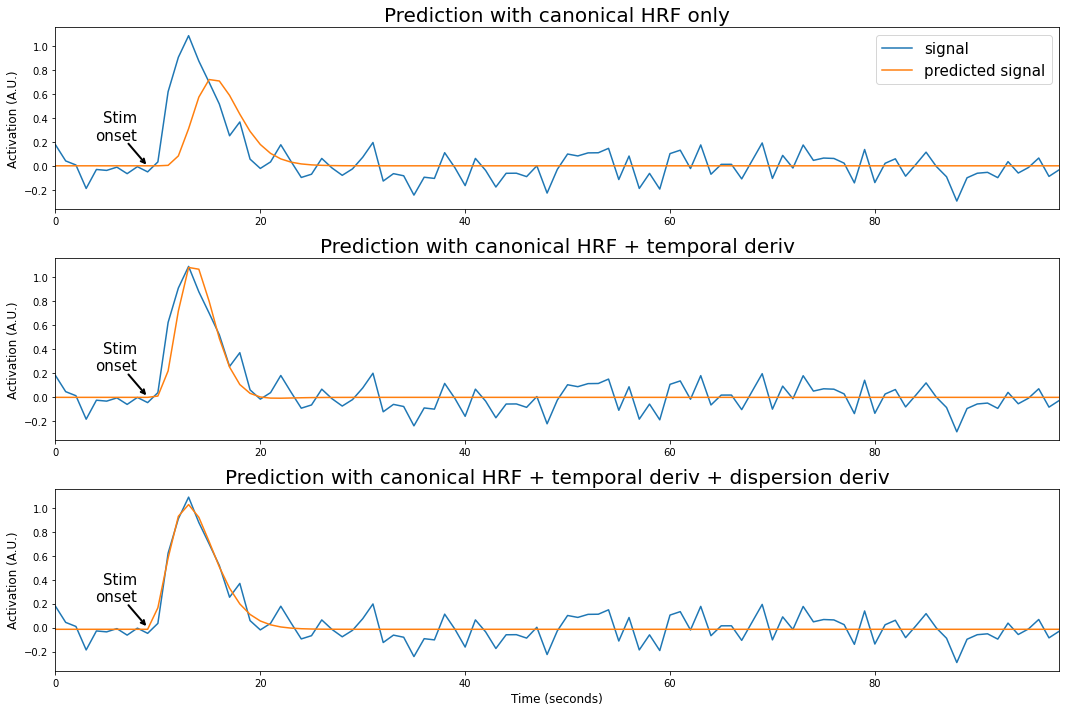

In [ ]:
predictor_hrf_temporal = np.convolve(onset_array, sg_hrf_temp)[:example_vox.size]
design_mat2 = np.hstack((design_mat, predictor_hrf_temporal[:, np.newaxis]))

# Do regression with HRF + temp deriv HRF
beta2 = lstsq(design_mat2, example_vox, rcond=None)[0]
yhat2 = design_mat2.dot(beta2)

# Replot the canonical HRF fit
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(example_vox)
plt.plot(yhat1)
plt.xlim(0, 98)
plt.ylabel("Activation (A.U.)", fontsize=12)
plt.annotate('', xy=(9, 0), xytext=(7, 0.2),
             arrowprops=dict(arrowstyle='->', lw=2))
plt.text(8, 0.22, 'Stim\nonset', horizontalalignment='right', fontsize=15)
plt.title("Prediction with canonical HRF only", fontsize=20)
plt.legend(['signal', 'predicted signal'], fontsize=15)

# Plot model with temp deriv HRF
plt.subplot(3, 1, 2)
plt.plot(example_vox)
plt.plot(yhat2)
plt.xlim(0, 98)
plt.ylabel("Activation (A.U.)", fontsize=12)
plt.annotate('', xy=(9, 0), xytext=(7, 0.2),
             arrowprops=dict(arrowstyle='->', lw=2))
plt.text(8, 0.22, 'Stim\nonset', horizontalalignment='right', fontsize=15)
plt.title("Prediction with canonical HRF + temporal deriv", fontsize=20)

# Make dispersion HRF predictor and do regression
predictor_hrf_dispersion = np.convolve(onset_array, sg_hrf_disp)[:example_vox.size]
design_mat3 = np.hstack((design_mat2, predictor_hrf_dispersion[:, np.newaxis]))
beta3 = lstsq(design_mat3, example_vox, rcond=None)[0]
yhat3 = design_mat3.dot(beta3)

# Plot model with temp deriv HRF + dispersion deriv HRF
plt.subplot(3, 1, 3)
plt.plot(example_vox)
plt.plot(yhat3)
plt.xlim(0, 98)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Activation (A.U.)", fontsize=12)
plt.annotate('', xy=(9, 0), xytext=(7, 0.2),
             arrowprops=dict(arrowstyle='->', lw=2))
plt.text(8, 0.22, 'Stim\nonset', horizontalalignment='right', fontsize=15)
plt.title("Prediction with canonical HRF + temporal deriv + dispersion deriv", fontsize=20)

plt.tight_layout()
plt.show()

As you can see, the prediction improves quite a bit when including the temporal derivative and (although to a lesser extent) the dispersion derivative! But how should we interpret the beta-parameters? Well, usually people don't really interpret the temporal and dispersion derivative HRFs (unless they're interested in lag/width of the HRF), because most researchers are interesting in the activation/deactivation (the amplitude) of voxels in response to a stimulus, which corresponds to the beta-parameters associated with the canonical HRF. So, basically, the temporal and dispersion derivatives are only used to "correct" for deviations in terms of lag/shape from the canonical HRF!

So, should you then always use a (gamma) basis set? To be honest, people are quite divided on the topic of whether to use basis sets or a canonical HRF. In our experience, derivatives (e.g. in the gamma basis sets) offers little improvement over a canonical HRF, but it doesn't hurt either (given that you have 'enough' degrees of freedom).

Anyway, time for a ToDo!

<div class='alert alert-warning'>
<b>ToDo: Large</b>
</div>

Reanalyze the voxel signal with the separate conditions (like the last ToDo), but this time with a gamma basis set instead of the canonical HRF! Calculate the beta-parameters, MSE, and $R^2$. Store the MSE in a variable named `mse_gbf` and $R^2$ in a variable named `r2_gbf`. 

Please implement this ToDo in "steps", such that we can test intermediate output:
1. Convolve the circle predictor (`predictor_circles`) and the squares predictor (`predictor_squares`) with the three HRF basis functions (canonical, temporal deriv., dispersion deriv.) separately, giving you 6 predictors, stack them together and add an intercept (make sure the intercept is the first column). Store your design matrix in a variable named `X_gbf`; (2 points)
2. Run linear regression (your DV is the variable `voxel_signal`) and store your betas in a variable named `betas_gbf`; (1 point)
3. Calculate R-squared and store it in a variable named `r2_gbf`; (1 point)
4. Calculate MSE and store it in a variable named `mse_gbf`; (1 point)

Some tips:
- you can use the definitions of the HRFs from earlier (`sg_hrf`, `sg_hrf_temp`, and `sg_hrf_disp`)
- make sure that your design-matrix has, eventually, 7 colums (3 predictors x 2 conditions + intercept)
- don't forget to trim and downsample your predictors/design matrix after convolution! (remember: our fMRI signal has 400 samples)

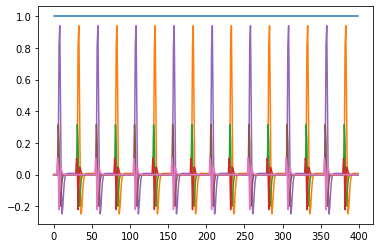

In [ ]:
# Step 1: convolve the predictors (don't forget to trim and downsample)!
# Hint: print the shape of your predictors after convolving, trimming, and downsampling - 
# does this shape correspond to the number of datapoints of the experiment?

# We have created the binary predictors for you already
predictor_circles = np.zeros(800)
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros(800)
predictor_squares[onsets_squares] = 1

## convolce, squeeze, trim and add the axis back
pred_ci_conv1 = np.convolve(predictor_circles, dg_hrf, 'full')[: predictor_circles.size: 2][:, np.newaxis]
pred_ci_conv2 = np.convolve(predictor_circles, sg_hrf_temp, 'full')[: predictor_circles.size: 2][:, np.newaxis]
pred_ci_conv3 = np.convolve(predictor_circles, sg_hrf_disp, 'full')[: predictor_circles.size: 2][:, np.newaxis]
pred_sq_conv1 = np.convolve(predictor_squares, dg_hrf, 'full')[: predictor_circles.size: 2][:, np.newaxis]
pred_sq_conv2 = np.convolve(predictor_squares, sg_hrf_temp, 'full')[: predictor_circles.size: 2][:, np.newaxis]
pred_sq_conv3 = np.convolve(predictor_squares, sg_hrf_disp, 'full')[: predictor_circles.size: 2][:, np.newaxis]


icept = np.ones((400, 1))

X_gbf = np.hstack((icept, pred_ci_conv1, pred_ci_conv2, pred_ci_conv3, pred_sq_conv1, pred_sq_conv2, pred_sq_conv3))

plt.plot(X_gbf)

In [ ]:
# Step 2: run linear regression

betas_gbf = lstsq(X_gbf, voxel_signal, rcond=None)[0]
betas_gbf

array([0.11943485, 2.48416555, 6.01573682, 5.46120612, 1.17893421,
       0.47911482, 1.4631582 ])

In [ ]:
''' Tests the above steps (hidden tests only)'''
betas_gbf_ans = ...


0.5350886898632136


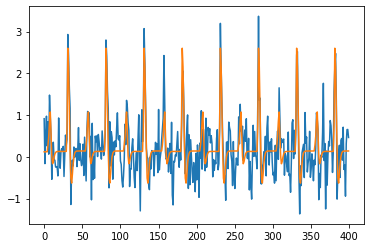

In [ ]:
# Step 3: calculate R-squared (and store it in a variable named r2_gbf)

y_hat_gbf = X_gbf.dot(betas_gbf)
r2_gbf = 1 - (np.sum((voxel_signal - y_hat_gbf) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
print(r2_gbf)
plt.plot(voxel_signal)
plt.plot(y_hat_gbf)


In [ ]:
''' Tests the above ToDo (only hidden tests)'''
y_hat_gbf = ...
r2_gbf_ans = ...


In [ ]:
# Step 3: calculate MSE (and store it in a variable named mse_gbf)


mse_gbf = ((y_hat_gbf - voxel_signal) ** 2).mean()



In [ ]:
''' Tests the above ToDo (only hidden tests)'''
y_hat_gbf = ...
mse_gbf_ans = ...


From what we've showed so far, hopefully, you noticed that how linear regression is applied to model a voxel signal is not that much different from 'regular' data, except for the convolution/HRF part. At this moment, you already know 95% of how univariate analysis works! There are, however, still a couple of concepts we need to address, which we'll do in the next section: statistical inference of model parameters.

## 3. Statistical inference of model parameters
From your statistics classes, you might remember that many software packages (e.g. SPSS or R) do not only return beta-parameters of linear regression models, but also t-values and p-values associated with the beta-parameters. Like beta-parameters, these statistics evaluate whether a beta-parameter (or combination of beta-parameters) differs significantly from 0 (or in fMRI terms: whether a voxel activates/deactivates significantly in response to a stimulus).

"Why would you need t-values and p-values - can't you just look at the beta-parameters?", you might ask. Well, the problem is, that **you should never interpret raw beta-values** - not in analyses of regular data nor in analyses of fMRI data. To illustrate the problem with this, let's look at an example.

In this example, we try to predict someone's height (in meters; y) using someone's weight (in kilos; X). (Note that the data is not really representative of the true relationship between height and weight.)

Anyway, let's run a linear regression using weight (in kilos) as a predictor for height (in meters).

0.004431965034401707


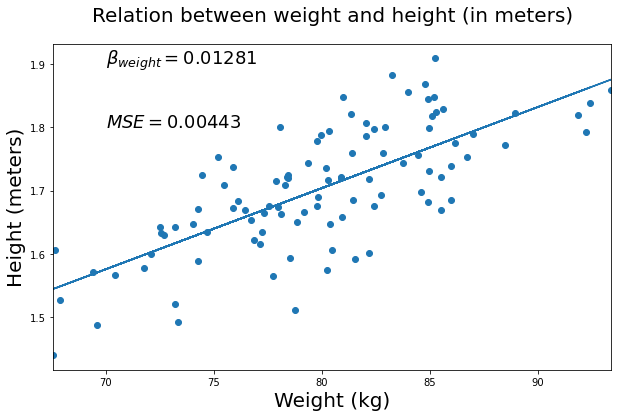

In [ ]:
data = np.load('data/weight_height_data.npz')
X, y = data['X'], data['y']

plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.title('Relation between weight and height (in meters)', y=1.05, fontsize=20)
plt.xlabel('Weight (kg)', fontsize=20)
plt.ylabel('Height (meters)', fontsize=20)

Xn = np.hstack((np.ones((y.size, 1)), X))
beta = lstsq(Xn, y, rcond=None)[0]
y_hat = Xn.dot(beta)
mse = np.mean((y_hat - y) ** 2)
plt.plot(X, Xn.dot(beta))
plt.xlim((X.min(), X.max()))
plt.text(70, 1.9, r'$\beta_{weight} = %.5f$' % beta[1], fontsize=18)
plt.text(70, 1.8, r'$MSE = %.5f$' % mse, fontsize=18)
print(mse)
plt.show()

Well, quite a modest beta-parameter on the one hand, but on the other hand the Mean Squared Error is also quite low. 
Now, to illustrate the problem of interpretating 'raw' beta-weights, let's rephrase our objective of predicting height based on weight: we'll try to predict **height in centimeters** based on weight (still in kilos). So, what we'll do is just rescale the data points of y (height in meters) so that they reflect height in centimeters. We can simply do this by multipling our y-variable by 100.

In [ ]:
y_cm = y * 100

Now, you wouldn't expect our model to change, right? We only rescaled our target ... As you'll see below, this actually changes a lot!

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Run linear regression like the previous code block, but with `y_cm` instead of `y` as the target variable. You can use the same design (`Xn`). Calculate the beta-parameter and MSE.

In [ ]:
# implement linear regression for y_cm using Xn here:

beta_cm = lstsq(Xn, y_cm, rcond=None)[0]
y_hat_cm = Xn.dot(beta_cm)
mse_cm = np.mean((y_hat_cm - y_cm) ** 2)

mse_cm

44.3196503440171

If you did it correctly, when you compare the beta-parameters between the two models (one where y is in meters, and one where y is in centimeters), you see a massive difference - a 100 fold difference to be exact\*! This is a nice example where you see that the (raw) value of the beta-parameter is completely dependent on the scale of your variables. (Actually, you could either rescale X or y; both will have a similar effect on your estimated beta-parameter.)

-----------
\* Note that the MSE is a 100,000 times larger in the model with y_cm compared to y (in meters). This is because the influence of scale (factor 100) is squared when calculating mean **squared** error!

### 3.1. How to compute statistics of the GLM
So, you've seen that interpreting beta-parameters by themselves is useless because their value depends very much on the scale of your variables. But how should we, then, interpret the effects of our predictors on our target-variable? From the plots above, you probably guessed already that it has something to do with the MSE of our model (or, more generally, the model fit). That is indeed the case. As you might have noticed, not only the beta-parameters depend on the scale of your data, the errors (residuals) depend on the scale as well. In other words, not only the *effect* (beta-values) but also the *noise* (errors, MSE) depend on the scale of the variables! 

#### 3.1.1. T-values
In fact, the key to getting interpretable effects of our predictors is to divide ("normalize") our beta-parameter(s) by some quantity that summarizes how well our model describes the data. This quantity is the **standard error of the beta-parameter**, usually denoted by $SE_{\beta}$. The standard error of the beta-parameter can be computed by taking the square root of the **variance of the beta-parameter**. If we'd divide our beta-estimate with it's standard error, we compute a statistic you are all familiar with: the t-statistic! Formally:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{SE_{\hat{\beta}}} = \frac{\hat{\beta}}{\sqrt{\mathrm{variance}(\hat{\beta})}}
\end{align}



<div class='alert alert-info'>
    <b>ToThink</b>
</div>

Suppose that I know the $SE$ of a particular beta-parameter. How can I derive the variance of that parameter (i.e., how do I go from the $SE$ to the variance)? And yes, the answer is as straightforward as you'd think.

Another way to think about it is that the t-value is the "effect" ($\hat{\beta}$) divided by your (un)certainty or confidence in the effect ($SE_{\hat{\beta}}$). In a way, you can think of t-values as "uncertainty-normalized" effects.

So, what drives (statistical) uncertainty about "effects" (here: $\hat{\beta}$ parameters)? To find out, let's dissect the uncertainty term, $SE_{\beta}$, a little more. The standard error of a parameter can interpreted conceptually as the "unexplained variance of the model" (or **noise**) multiplied with the "design variance" (or: **the variance of the parameter due to the design**). In this lab, we won't explain what *design variance* means or how to compute this, because it will complicate things too much for now. Next week will be all about this term. 

For now, we treat "design variance", here, as some known (constant) value. So, with this information, we can construct a conceptual formula for the standard error of our parameter(s):


\begin{align}
SE_{\hat{\beta}} = \sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}
\end{align}

Now we also create a "conceptual formula" for the t-statistic:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{SE_{\hat{\beta}}} = \frac{\mathrm{effect}}{\sqrt{\mathrm{noise} \cdot \mathrm{design\ variance}}}
\end{align}

This (conceptual) formula involving effects, noise, and design variance is probably **the most important concept of this course**. The effects (t-values) we measure in GLM analyses of fMRI data depend on two things: the effect measured ($\hat{\beta}$) and the (un)certainty of the effect ($SE_{\hat{\beta}}$), of which the latter term can be divided into the unexplained variance ("noise") and the design variance (uncertainty of the parameter due to the design).

These two terms (noise and design variance) will be central to the next couple of weeks of this course. In week 3 (topic: design of experiments), we'll focus on how to optimize our t-values by minimizing the "design variance" term. In week 4 (topic: preprocessing), we'll focus on how to optimize our t-values by minimizing the error.

While we're going to ignore the design variance, we are, however, going to learn how to calculate the "noise" term.

In fact, the noise term is *very* similar to the MSE, but instead of taking the *mean* of the squared residuals, we sum the squared residuals ("sums of squared erros", SSE) and divide it by the model's degrees of freedom (DF). People usually use the $\hat{\sigma}^{2}$ symbol for this noise term:

\begin{align}
\mathrm{noise} = \hat{\sigma}^{2} = \frac{\sum_{i=1}^{N}(\hat{y_{i}} - y_{i})^2}{\mathrm{df}} 
\end{align}

where the degrees of freedom (df) are defined as the number of samples ($N$) minus the number of predictors *including the intercept* ($P$):

\begin{align}
\mathrm{df} = N - P
\end{align}

So, the formula of the t-statistic becomes:

\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}}{\sqrt{\frac{\sum_{i=1}^{N}(\hat{y_{i}} - y_{i})^2}{\mathrm{df}} \cdot \mathrm{design\ variance}}}
\end{align}

Alright, enough formulas. Let's see how we can compute these terms in Python. We're going to calculate the t-statistic of the weight-predictor for both models (the meter and the centimeter model) to see whether we can show that essentially the (normalized) effect of weight on height in meters is the same as the effect on heigh in centimeters; in other words, we are going to investigate whether the conversion to t-values "normalizes" the beta-parameters.

First, we'll create a function for you to calculate the design-variance. You *don't* have to understand how this works; we're going to explain this to you in detail next week.

In [ ]:
def design_variance(X, which_predictor=1):
    ''' Returns the design variance of a predictor (or contrast) in X.
    
    Parameters
    ----------
    X : numpy array
        Array of shape (N, P)
    which_predictor : int or list/array
        The index of the predictor you want the design var from.
        Note that 0 refers to the intercept!
        Alternatively, "which_predictor" can be a contrast-vector
        (which will be discussed later this lab).
        
    Returns
    -------
    des_var : float
        Design variance of the specified predictor/contrast from X.
    '''
    
    is_single = isinstance(which_predictor, int)
    if is_single:
        idx = which_predictor
    else:
        idx = np.array(which_predictor) != 0
    
    c = np.zeros(X.shape[1])
    c[idx] = 1 if is_single == 1 else which_predictor[idx]
    des_var = c.dot(np.linalg.pinv(X.T.dot(X))).dot(c.T)
    return des_var

So, if you want the design variance of the 'weight' parameter in the varianble `Xn` from before, you do:

In [ ]:
# use which_predictor=1, because the weight-column in Xn is at index 1 (index 0 = intercept)
design_variance_weight_predictor = design_variance(Xn, which_predictor=1)
print("Design variance of weight predictor is: %.6f " % design_variance_weight_predictor)

Design variance of weight predictor is: 0.000334 


Alright, now we only need to calculate our noise-term ($\hat{\sigma}^2$):

In [ ]:
# Let's just redo the linear regression (for clarity)
beta_meter = lstsq(Xn, y, rcond=None)[0]
y_hat_meter = Xn.dot(beta_meter)

N = y.size
P = Xn.shape[1]
df = (N - P)
print("Degrees of freedom: %i" % df)
sigma_hat = np.sum((y - y_hat_meter) ** 2) / df
print("Sigma-hat (noise) is: %.3f" % sigma_hat)
design_variance_weight = design_variance(Xn, 1)

Degrees of freedom: 98
Sigma-hat (noise) is: 0.005


Now we can calculate the t-value:

In [ ]:
t_meter = beta_meter[1] / np.sqrt(sigma_hat * design_variance_weight)
print("The t-value for the weight-parameter (beta = %.3f) is: %.3f" % (beta_meter[1], t_meter))

The t-value for the weight-parameter (beta = 0.013) is: 10.431


That's it! There's not much more to calculating t-values in linear regression. Now it's up to you to do the same thing and calculate the t-value for the model of height in centimeters, and check if it is the same as the t-value for the weight parameter in the model with height in meters.

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Calculate the t-statistic for the beta from the centimeter-model you calculated earlier. Store the value in a new variable named `t_centimeter`. Note: you don't have to calculate the design variance again (because `X` hasn't changed!) - you can reuse the variable `design_variance_weight`.

In [ ]:
# Calculate the t-value here!
beta_cm = lstsq(Xn, y_cm, rcond=None)[0]
y_hat_cm = Xn.dot(beta_cm)

N = y_cm.size
P = Xn.shape[1]
df = (N - P)
print("Degrees of freedom: %i" % df)
sigma_hat_cm = np.sum((y_cm - y_hat_cm) ** 2) / df
print("Sigma-hat (noise) is: %.3f" % sigma_hat_cm)
design_variance_weight = design_variance(Xn, 1)

t_cm = beta_cm[1] / np.sqrt(sigma_hat_cm * design_variance_weight)
print("The t-value for the weight-parameter (beta = %.3f) is: %.3f" % (beta_cm[1], t_cm))

Degrees of freedom: 98
Sigma-hat (noise) is: 45.224
The t-value for the weight-parameter (beta = 1.281) is: 10.431


#### 3.2.2. P-values
As you can see, calculating t-values completely solves the 'problem' of uninterpretable beta-coefficients! So, remember never to interpret raw beta-coefficients (at least in fMRI), and always to convert them to t-values first!

Now, the last thing you need to know is how to calculate the significance of your t-value, or in other words, how you calculate the corresponding p-value. You probably remember that the p-value corresponds to the area under the curve of a t-distribution associated with your t-value *and more extreme values*: 
![test](http://www.nku.edu/~statistics/Test_o12.gif)

The function `t.sf(t_value, df)` from the `stats` module of the `scipy` package does exactly this. Importantly, this function ALWAYS returns the right-tailed p-value. For negative t-values, however, you'd want the left-tailed p-value. One way to remedy this, is to always pass the absolute value of your t-value - `np.abs(t_value)` to the `t.sf()` function. Also, the `t.sf()` function by default returns the one-sided p-value. In practice you'd want the two-sided p-value, so what you can simply do is multiply the returned p-value by two to get the corresponding two-sided p-value. 

Let's see how we'd do that in practice:

In [ ]:
from scipy.stats import t

# take the absolute by np.abs(t)
p_value = t.sf(np.abs(t_meter), df) * 2 # multiply by two to create a two-tailed p-value
print('The p-value corresponding to t(%i) = %.3f is: %.8f' % (df, t_meter, p_value))

The p-value corresponding to t(98) = 10.431 is: 0.00000000


<div class='alert alert-info'>
<b>ToThink</b>
</div>

So by now you understand why it is important **not** to interpret raw beta parameters, because these depend heavility on the scale of your data. One could argue that this is not relevant for fMRI data because all data (i.e. different voxels in the brain) all measure the same type of signal, so their scale shouldn't differ that much. This, however, is a false assumption.

Think of two reasons why voxels might differ in their scale and write them down in the text cell below.

*Some possible answers:*

1. Inhomogeneity of the signal at some spots (lower signal)
2. Type of scanner.
3. Different tissue types (white matter, gray matter, CSF, mix)
4. Closeness to the headcoil (subcortical structures for example have generally a lower SNR)

### 3.3. Contrasts in the GLM
We're almost done! We're really at 99% of what you should know about the GLM and fMRI analysis\*. The only thing that we need to discuss is **contrasts**. Contrasts are basically follow-up statistical tests of beta-parameter(s), and most importantly, *between* beta-parameters, to test hypotheses you might have about your predictors. Essentially, it is just an extension of the t-test we've explained earlier. 

---
\* Those who remembered their intro statistics classes accurately might recall the assumptions of linear regression, which as some might have noticed, could be violated in linear regression of fMRI data! This is because one of linear regression's assumptions is about **independent errors**, meaning that their should be no temporal correlation ("autocorrelation") between the residuals of a linear regression model. The residuals of univariate fMRI models are, often, autocorrelated due to low-frequency drifts, which make the inference of t-values in fMRI problematic. Fortunately, there are ways to deal with this autocorrelation-issue. This will be explained next week (preprocessing). It is important to realize that, fundamentally, linear regression of univariate fMRI data (or regression of *any* temporal signal, really) likely violates an important assumption, but also realize that the "mechanics" and logic of linear regression of how we learned it thus far still holds!

There are two main types of contrasts for t-tests:

**1. contrast of a beta-parameter 'against baseline'.**

This type of contrast basically tests the hypothesis: "Does my predictor(s) have *any* effect on my dependent variable?" In other words, it tests the following hypothesis:
* $H_{0}: \beta = 0$        (our null-hypothesis, i.e. no effect)
* $H_{a}: \beta \neq 0$     (our alternative hypotehsis, i.e. *some* effect)


**2. contrast between beta-parameters.**

This type of contrast basically tests hypotheses such as "Does predictor 1 have a larger effect on my dependent variable than predictor 1?". In other words, it tests the following hypothesis:
* $H_{0}: \beta_{1} - \beta_{2} = 0$ (our null-hypothesis, i.e. there is no difference)
* $H_{a}: \beta_{1} - \beta_{2} \neq 0$     (our alternative hypotehsis, i.e. there is some difference)

Let's look at an example of how we would evaluate a simple hypothesis that a beta has an *some* effect on the dependent variable. Say we'd have an experimental design with 6 conditions:

* condition 1: images of male faces with a happy expression
* condition 2: images of male faces with a sad expression
* condition 3: images of male faces with a neutral expression
* condition 4: images of female faces with a happy expression
* condition 5: images of female faces with a sad expression
* condition 6: images of female faces with a neutral expression

Let's assume we have fMRI data from a run with 100 volumes. We then have a target-signal of shape ($100 \times 1$) and a design-matrix (after convolution with a canonical HRF) of shape ($100 \times 7$) (the first predictor is the intercept!). We load in this data below:

In [ ]:
data = np.load('data/data_contrast_example.npz')
X, y = data['X'], data['y']

print("Shape of X: %s" % (X.shape,))
print("Shape of y: %s" % (y.shape,))

Shape of X: (100, 7)
Shape of y: (100,)


After performing linear regression with these 6 predictors (after convolving the stimulus-onset times with an HRF, etc. etc.), you end up with 7 beta values:

In [ ]:
betas = lstsq(X, y, rcond=None)[0]
betas = betas.squeeze()  # this is important for later
print("Betas corresponding to our 6 conditions (and intercept):\n%r" % betas.T)

Betas corresponding to our 6 conditions (and intercept):
array([ 0.08208567, -0.21982422, -0.16284892,  0.53208935,  0.26214462,
        0.38945094,  0.21565532])


The first beta corresponds to the intercept, the second beta to the male/happy predictor, the third beta to the male/sad predictor, etc. etc. Now, suppose that we'd like to test whether images of male faces with a sad expression have an influence on voxel activity (our dependent variable). 

The first thing you need to do is extract this particular beta value from the array with beta values (I know this sounds really trivial, but bear with me):

In [ ]:
beta_male_sad = betas[2]
print("The extracted beta is %.3f" % beta_male_sad)

The extracted beta is -0.163


In neuroimaging analyses, however, this is usually done slightly differently: using **contrast-vectors**. Basically, it specifies your specific hypothesis about your beta(s) of interest in a vector. Before explaining it in more detail, let's look at it in a code example:

In [ ]:
# Again, we'd want to test whether the beta of "male_sad" is different from 0
contrast_vector = np.array([0, 0, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum() # we simply elementwise multiply the contrast-vector with the betas and sum it!
print('The beta-contrast is: %.3f' % contrast)

The beta-contrast is: -0.163


"Wow, what a tedious way to just select the third value of the beta-array", you might think. And, in a way, this is indeed somewhat tedious for a contrast against baseline. But let's look at a case where you would want to investigate whether two betas are different - let's say whether male sad faces have a larger effect on our voxel than male happy faces. Again, you *could* do this:

In [ ]:
beta_difference = betas[2] - betas[1]
print("Difference between betas: %.3f" % beta_difference)

Difference between betas: 0.057


... but you could also use a contrast-vector:

In [ ]:
contrast_vector = np.array([0, -1, 1, 0, 0, 0, 0])
contrast = (betas * contrast_vector).sum()
print('The contrast between beta 2 and beta 1 is: %.3f' % contrast)
print('This is exactly the same as beta[2] - beta[1]: %.3f' % (betas[2]-betas[1]))

The contrast between beta 2 and beta 1 is: 0.057
This is exactly the same as beta[2] - beta[1]: 0.057


"Alright, so using contrast-vectors is just a fancy way of extracting and subtracting betas from each other ...", you might think. In a way, that's true. But you have to realize that once the hypotheses you want to test become more complicated, using contrast-vectors actually starts to make sense.

Let's look at some more elaborate hypotheses. First, let's test whether male faces lead to higher voxel activity than female faces, *regardless of emotion*:

In [ ]:
# male faces > female faces
contrast_vector = [0, 1, 1, 1, -1, -1, -1]
male_female_contrast = (contrast_vector * betas).sum()
print("Male - female contrast (regardless of expression): %.2f" % male_female_contrast)

Male - female contrast (regardless of expression): -0.72


... or whether emotional faces (regardless of *which* exact emotion) lead to higher activity than neutral faces:

In [ ]:
# Emotion (regardless of which emotion, i.e., regardless of sad/happy) - neutral
contrast_vector = [0, 1, 1, -2, 1, 1, -2]
emo_neutral_contrast = (contrast_vector * betas).sum()
print("Emotion - neutral contrast (regardless of which emotion): %.2f" % emo_neutral_contrast)

Emotion - neutral contrast (regardless of which emotion): -1.23


See how contrast-vectors come in handy when calculating (more intricate) comparisons? In the male-female contrast, for example, instead 'manually' picking out the betas of 'sad_male' and 'happy_male', averaging them, and subtracting their average beta from the average 'female' betas ('happy_female', 'sad_female'), you can simply specify a contrast-vector, multiply it with your betas, and sum them. That's it.

<div class='alert alert-info'>
<b>ToThink</b>
</div>

In the last contrast (`emo_neural_contrast`), we set all the "emotional" predictors (sad/happy) to 1, but the neutral predictors to minus *2* ... Why are these set to -2 and not -1? Write your answer below.

They have to sum to 0. If you'd use -1, you would "weigh" the emotional predictors twice as heavy as the neutral predictors.

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Create a contrast vector for the hypothesis: sad faces (regardless whether it's male or female) activate this voxel more than neutral faces (regardless of whether it's male/female). Multiply this contrast vector with the betas and store the result in a variable named `contrast_todo`.

In [ ]:
# Implement the sad - neutral contrast here:
cvec = [0, 0, 1, -1, 0, 1, -1]
contrast_todo = (cvec * betas).sum()
contrast_todo

-0.521142649253213

In [ ]:
''' Tests the above ToDo (only hidden tests). '''

assert(np.round(contrast_todo, 3) == -0.521)


We're not only telling you about contrasts because we think it's an elegant way of computing beta-comparisons, but also because virtually every major neuroimaging software package uses them, so that you can specify what hypotheses you exactly want to test! You'll also see this when we're going to work with FSL (in week 5!) to perform automated whole-brain linear regression analyses.

Knowing how contrast-vectors work, we now can extend our formula for t-tests of beta-parameters such that they can describe **every possible test** (not only t-tests, but also ANOVAs, F-tests, etc.) of betas (against 'baseline') or between betas that you can think of: 

Our 'old' formula of the t-test of a beta-parameter:
\begin{align}
t_{\hat{\beta}} = \frac{\hat{\beta}_{j}}{SE_{\hat{\beta}}}
\end{align}

And now our 'generalized' version of the t-test of *any* contrast/hypothesis:

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\sum_{j=1}^{P}{c_{j}\hat{\beta}_{j}}}{SE_{\mathbf{c}\hat{\beta}}} 
\end{align}

in which $\mathbf{c}$ represents the entire contrast-vector, and $c_{j}$ represents the $j^{th}$ value in our contrast vector. By the way, we can simplify the (notation of the) numerator a little bit using some matrix algebra trick. Remember that multiplying two (equal lengt) vectors with each other and then summing the values together is the same thing as the (inner) "dot product" between the two vectors? 

Note that you can also write this elementwise multiplication and sum of the contrast-vector and the betas in a vectorized way (using the dot-product):

\begin{align}
t_{\mathbf{c}\hat{\beta}} = \frac{\mathbf{c}\hat{\beta}}{SE_{\mathbf{c}\hat{\beta}}} 
\end{align}

<div class='alert alert-warning'>
    <b>ToDo</b>
</div>

Convince yourself that the elementwise multiplication and sum is mathematically exactly the same as the dot product! Below, we initialized a hypothetical vector with beta-values (`some_betas`) and a hypothetical contrast-vector (`some_cvec`). First, implement the "multiply and sum" approach and then implement the "dot product" approach. You should find that it gives you exactly the same value: -3.34

In [ ]:
some_betas = np.array([1.23, 2.95, 3.33, 4.19])
some_cvec = np.array([1, 1, -1, -1])

# Try to implement both approaches and convince yourself that it's
# mathematically the same!


So, you need the contrast vector in the *numerator* of the t-value formula (i.e., $\mathbf{c}\hat{\beta}$), but it turns out that you actually also need the contrast-vector in the denominator, because it's part of the calculation of design variance. Again, we will discuss how this works exactly next week. In the function `design_variance`, it is also possible to calculate design variance for a particular contrast (not just a single predictor) by passing a contrast vector to the `which_predictor` argument.

We'll show this below:

In [ ]:
# E.g., get design-variance of happy/male - sad/male
c_vec = np.array([0, 1, -1, 0, 0, 0, 0])  # our contrast vector!
dvar = design_variance(X, which_predictor=c_vec)  # pass c_vec to which_predictor
print("Design variance of happy/male - sad/male: %.3f" % dvar)

Design variance of happy/male - sad/male: 0.024


For the rest of ToDos this lab (you're almost done, don't worry!), make sure to pass your contrast-vector to the `design_variance` function in order to calculate it correctly.

Now you know enough to do it yourself!

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Calculate the t-value and p-value for the hypothesis "sad faces have a larger effect than happy faces (regardless of gender) on our dependent variabe" (i.e. voxel activity). In other words, test the hypothesis: $\beta_{sad} - \beta_{happy} \neq 0$ (note that this is a two-sided test!).

Store the t-value and p-value in the variables `tval_todo` and `pval_todo` respectively. We reload the variables below (we'll call them `X_new` and `y_new`) to make sure you're working with the correct data. Note that the `X_new` variable already contains an intercept; the other six columns correspond to the different predictors (male/hapy, male/sad, etc.). In summary, you have to do the following:

- (you don't have to calculate the betas; this has already been done (stored in the variable `betas`)
- calculate "sigma-hat" ($SSE / \mathrm{df}$)
- calculate design-variance (use the `design_variance` function with a proper contrast-vector)
- calculate the contrast ($\mathbf{c}\hat{\beta}$)
- calculate the t-value and p-value

In [ ]:
data = np.load('data_contrast_example.npz')
X_new, y_new = data['X'], data['y']

print("Shape of X: %s" % (X_new.shape,))
print("Shape of y: %s" % (y_new.shape,))

from scipy.stats import t

cvec = ...
this_dvar = ...
y_hat = ...
this_sse = ...
tval_todo = ...
pval_todo = ...


In [ ]:
''' Part 1 of testing the above ToDo (only hidden tests). '''

print("Only hidden tests!")

np.testing.assert_almost_equal(tval_todo, 1.2646, decimal=4)

In [ ]:
''' Part 2 of testing the above ToDo (only hidden tests). '''

print("Ony hidden tests!")

np.testing.assert_almost_equal(pval_todo, 0.2092, decimal=4)

### 3.4. F-tests on contrasts
In the previous section we discussed how to calculate t-values for single contrasts. However, sometimes you might have an hypothesis about multiple contrasts at the same time. This may sound weird, but let's consider an experiment.

Suppose you have data from an experiment in which you showed images circles which were either blue, red, or green. In that case, you have three predictors. Then, you could have very specific question, like "Do blue circles activate a voxel significantly compared to baseline", which corresponds to the following null and alternative hypothesis:

* $H_{0}: \beta_{blue} = 0$ (our null-hypothesis, i.e. there is no activation compared to baseline)
* $H_{a}: \beta_{blue} > 0$   (our alternative hypotehsis, i.e. blue activates relative to baseline)

However, you can also have a more general question, like "Does the presentation of *any* circle (regardless of color) activate a voxel compared to baseline?". This question represents the following null and alternative hypothesis:

* $H_{0}: \beta_{blue} = \beta_{red} = \beta_{green} = 0$
* $H_{a}: (\beta_{blue} > 0) \vee (\beta_{red} > 0) \vee (\beta_{green} > 0)$

The $\vee$ symbol in the alternative hypothesis means "or". So the alternative hypothesis nicely illustrates our question: is there *any* condition (circle) that activates a voxel more than baseline? This hypothesis-test might sound familiar, because it encompasses the **F-test**! In other words, an F-test tests *a collection of contrasts* together. In the example here, the F-test tests the following contrasts together (ignoring the intercept) of our beta-parameters:

* `[1, 0, 0]` ($red > 0$)
* `[0, 1, 0]` ($blue > 0$)
* `[0, 0, 1]` ($green > 0$)

Thus, a F-test basically tests this contrast-*matrix* all at once! Therefore, the F-tests is a type of "omnibus test"! 

Now, let's look at the math behind the F-statistic. The F-statistic for set of $K$ contrasts (i.e., the number of rows in the contrast-matrix) is defined as follows:

\begin{align}
F = (\mathbf{c}\hat{\beta})'[K\mathbf{c}((X'X)^{-1}\hat{\sigma}^{2})\mathbf{c}']^{-1}(\mathbf{c}\hat{\beta})
\end{align}

With a little imagination, you can see how the F-test is an extension of the t-test of a single contrast to accomodate testing a set of contrasts together. Don't worry, you don't have to understand how the formula for the F-statistic works mathematically and you don't have to implement this in Python. But you **do** need to understand what type of hypothesis an F-test tests! 

Let's practice this in a ToDo!

<div class='alert alert-warning'>
<b>ToDo</b>
</div>

Remember the temporal basis sets from before? Suppose we have an experiment with two conditions ("A" and "B") and suppose we've created a design matrix based on convolution with a single-gamma basis set (with a canonical HRF, its temporal derivative, and its dispersion derivative). Together with the intercept, the design matrix thus has 7 columns (2 conditions * 3 HRF + intercept).

The order of the columns is as follows:
* column 1: intercept
* column 2: canonical HRF "A"
* column 3: temporal deriv "A"
* column 4: dispersion deriv "A"
* column 5: canonical HRF "B"
* column 6: temporal deriv "B"
* column 7: dispersion deriv "B"

Suppose I want to test whether there is *any* difference in response to condition "A" ($A > 0$) compared to baseline, and *I don't care what element of the HRF caused it*. I can use an F-test for this. What would the corresponding contrast-*matrix* (in which each row represents a different contrast) look like? 

We've created an 'empty' (all-zeros) 2D matrix below with three rows. It's up to you to fill in the matrix such that it can be used to test the above question/hypothesis.

In [ ]:
# Fill in the correct values!
contrast_matrix = np.array([

    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]

])
